In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [2]:
cptac.download(dataset='Endometrial')

en = cptac.Endometrial()
proteomics = en.get_proteomics()
transcriptomics = en.get_transcriptomics()
clinical = en.get_clinical()

## Step 2: Data Cleaning and Choosing Attributes to A/B Test
First, we will drop columns we are not interested in, and then make each of the columns binary

In [3]:
cols_to_drop = ['Gender', 'Tumor_Site_Other', 
                'Tumor_Site', 'Patient_ID', 
                'Country', 'Treatment_naive', 
                'Age', 'Race', 'Ethnicity', 
                'Num_full_term_pregnancies']

for col in clinical.columns:
    if len(clinical[col].value_counts()) < 2:
        cols_to_drop.append(col)

annotations = clinical.copy()
annotations = annotations.drop(cols_to_drop, axis=1)

In [4]:
# Minor Data Cleaning

annotations['Myometrial_invasion_Specify'] = annotations['Myometrial_invasion_Specify'].replace('Not identified', np.nan)
annotations['Clin_Stage_Dist_Mets-cM'] = annotations['Clin_Stage_Dist_Mets-cM'].replace('Staging Incomplete', np.nan)
annotations['Path_Stage_Dist_Mets-pM'] = annotations['Path_Stage_Dist_Mets-pM'].replace('Staging Incomplete', np.nan)
annotations['Diabetes'] = annotations['Diabetes'].replace('Unknown', np.nan)

annotations['BMI'] = bf.binarizeRange(annotations, 'BMI', 18.5, 25, 'Healthy_BMI', 'Unhealthy_BMI')
annotations['LVSI'] = annotations['LVSI'].map({0.0:"No", 1.0:"Yes"})

for col in annotations.columns:
    if np.issubdtype(annotations[col].dtype, np.number):
        mean = annotations[col].mean()
        annotations[col]= bf.binarizeCutOff(annotations, col, mean,
                                            "Above_Mean("+str(round(mean, 2))+")",
                                            "Below_Mean("+str(round(mean, 2))+")")

In [5]:
annotations = deva.binarize_annotations(annotations)

## Step 3: Perform Outlier Analysis
Using the Blacksheep-outliers package, deva, we will create two tables: one of all the significant up-regulated genes per patient (which we will call outliers), and one of the q-values for significantly enriched genes based on our binarized clinical attributes (which we will call qvalues).

In [6]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(), 
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
09/05/2019 14:05:18:WARNING:No rows tested for fisherFDR_Proteomics_Tumor_Normal_Tumor_Tumor
09/05/2019 14:05:18:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Adjacent-normal
09/05/2019 14:05:18:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Enriched-normal
09/05/2019 14:05:18:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Myometrium-normal
09/05/2019 14:05:19:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 3_not-FIGO grade 3
09/05/2019 14:05:20:WARNING:No rows tested for fisherFDR_Histologic_type_Endometrioid
09/05/2019 14:05:22:WARNING:No rows tested for fisherFDR_Path_Stage_Primary_Tumor-pT_pT1b (FIGO IB)_not-pT1b (FIGO IB)
09/05/2019 14:05:23:WARNING:No rows tested for fisherFD

In [7]:
outliers_down, qvalues_down = deva.run_outliers(proteomics.transpose(), 
                                                annotations, 
                                                up_or_down='down', 
                                                aggregate=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1391: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
09/05/2019 14:06:10:WARNING:No rows tested for fisherFDR_Proteomics_Tumor_Normal_Tumor_Tumor
09/05/2019 14:06:10:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Adjacent-normal
09/05/2019 14:06:10:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Enriched-normal
09/05/2019 14:06:10:ERROR:There are not exactly 2 groups of samples, skipping Proteomics_Tumor_Normal_Myometrium-normal
09/05/2019 14:06:11:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 1_FIGO grade 1
09/05/2019 14:06:11:WARNING:No rows tested for fisherFDR_Histologic_Grade_FIGO_FIGO grade 3_not-FIGO grade 3
09/05/2019 14:06:11:WARNING:No rows tested for fisherFDR_Myometrial_invasion_Specify_under 50 %
09/05/2019 14:06:12:WARNING:No rows tested for fisherFDR_Hi

In [8]:
length = int(len(outliers.df.columns) / 2)
temp_outliers = outliers.df.transpose()
only_outliers_up = temp_outliers[:length]
outliers_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_up_dict[key] = value

In [9]:
length = int(len(outliers_down.df.columns) / 2)
temp_outliers_down = outliers_down.df.transpose()
only_outliers_down = temp_outliers_down[:length]
outliers_down_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index.get_level_values('Name'))
    outliers_down_dict[key] = value

## Step 4: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [10]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
for col in qvalues.df.columns:
    sig_col = bf.significantEnrichments(qvalues.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = qvalues.df.drop(col, axis=1)

In [11]:
#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
for col in qvalues_down.df.columns:
    sig_col = bf.significantEnrichments(qvalues_down.df, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
    else:
        results_down = qvalues_down.df.drop(col, axis=1)

In [12]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index)
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes

In [13]:
#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index)
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes

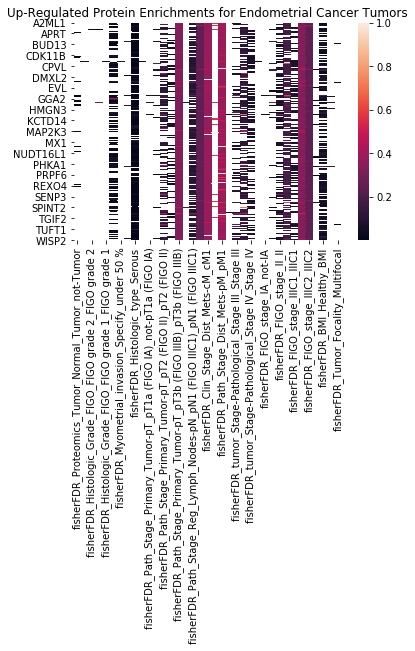

In [14]:
#Simple visualization
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Endometrial Cancer Tumors')
plt.show()

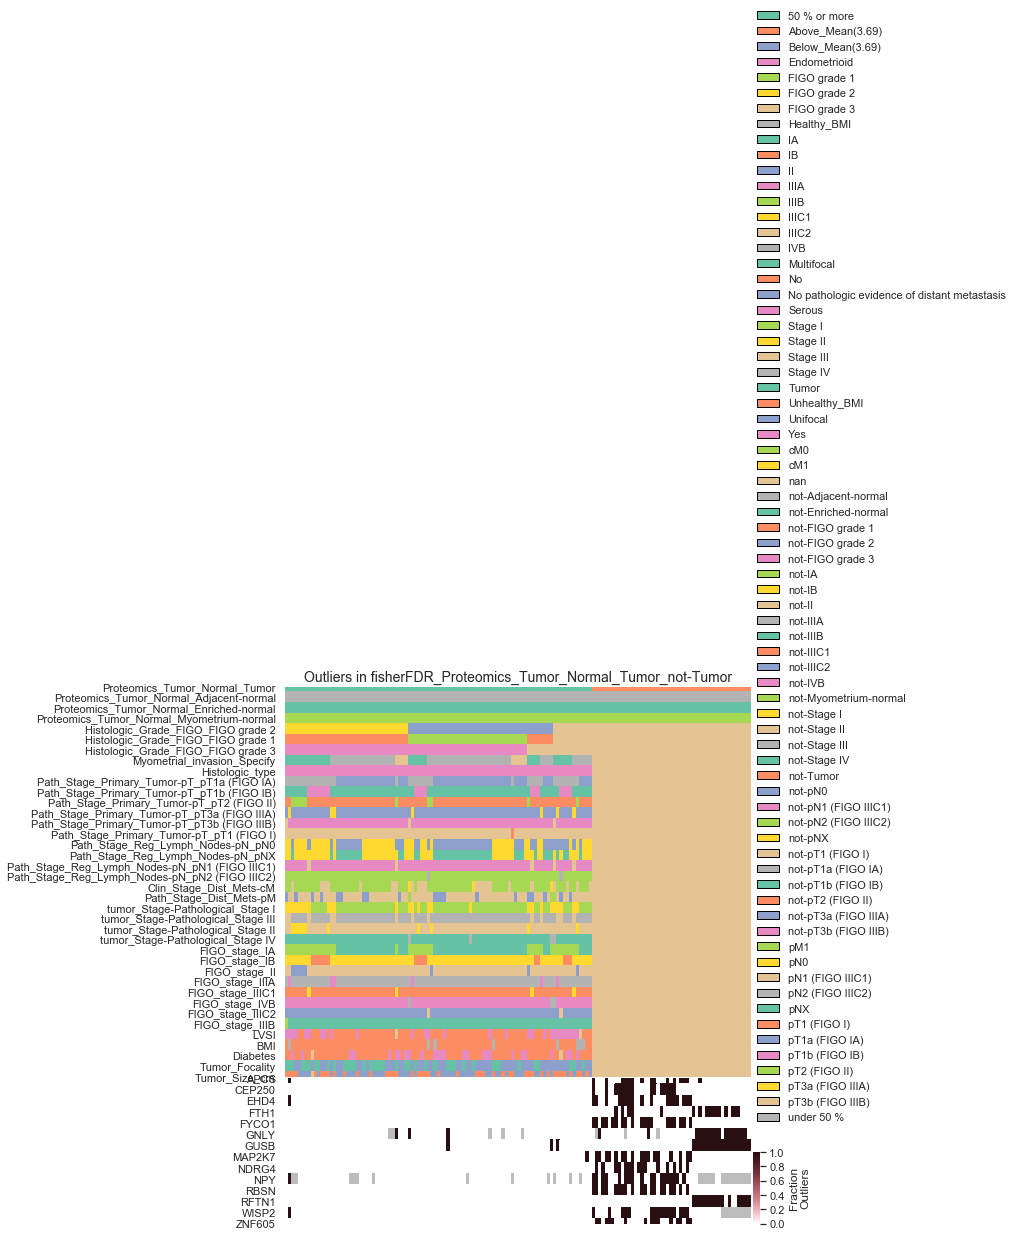

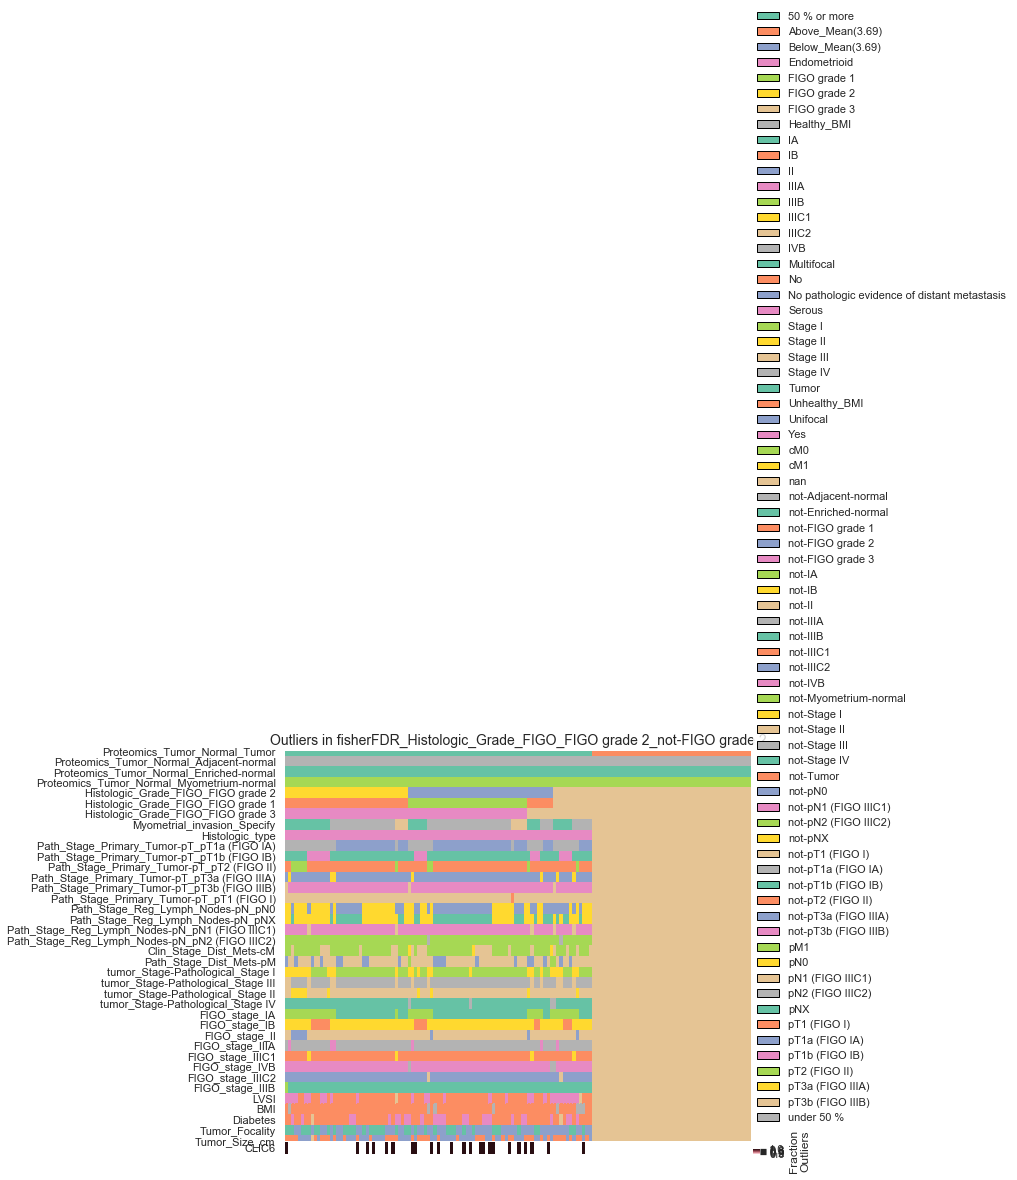

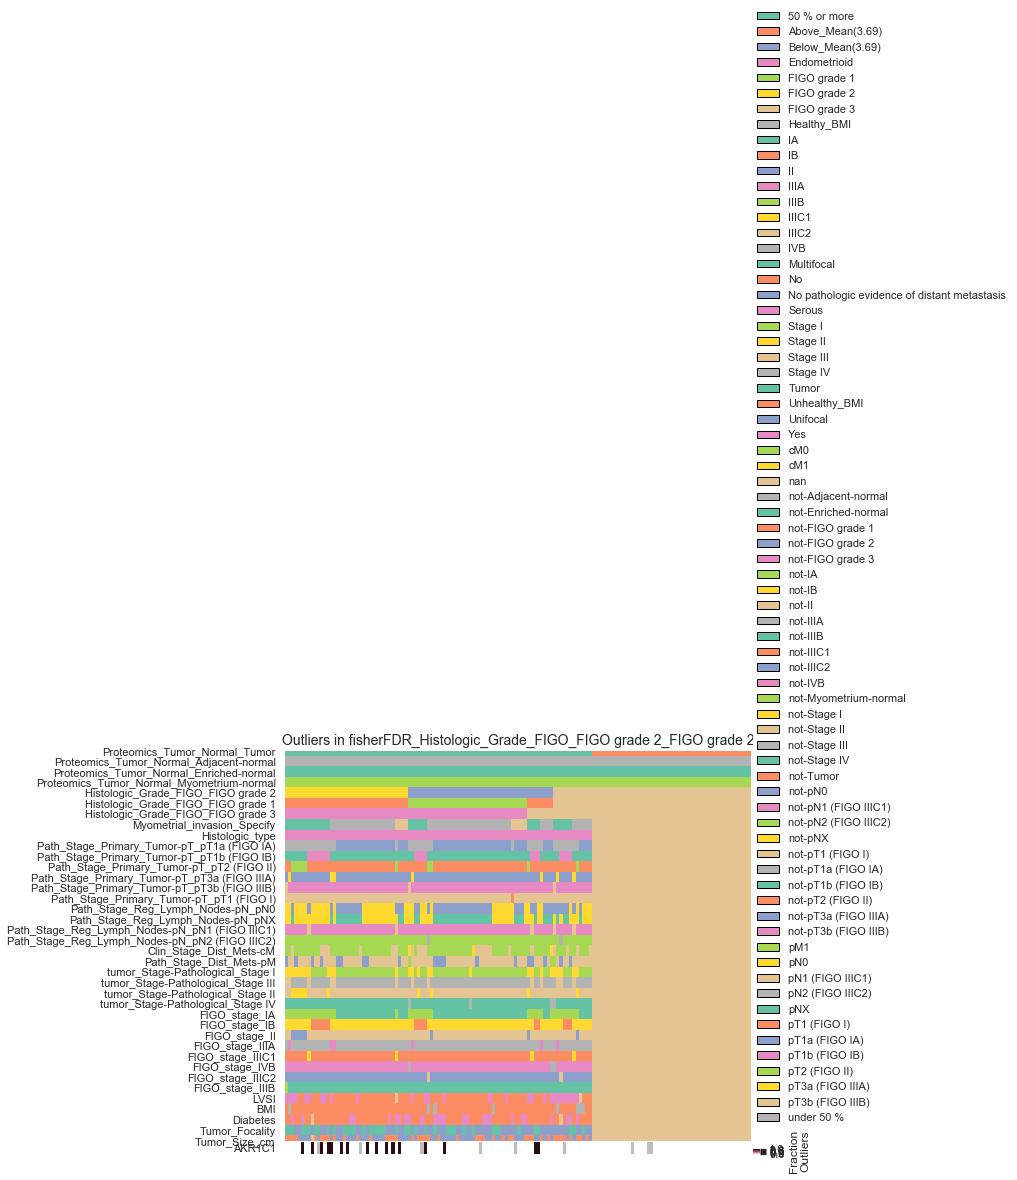

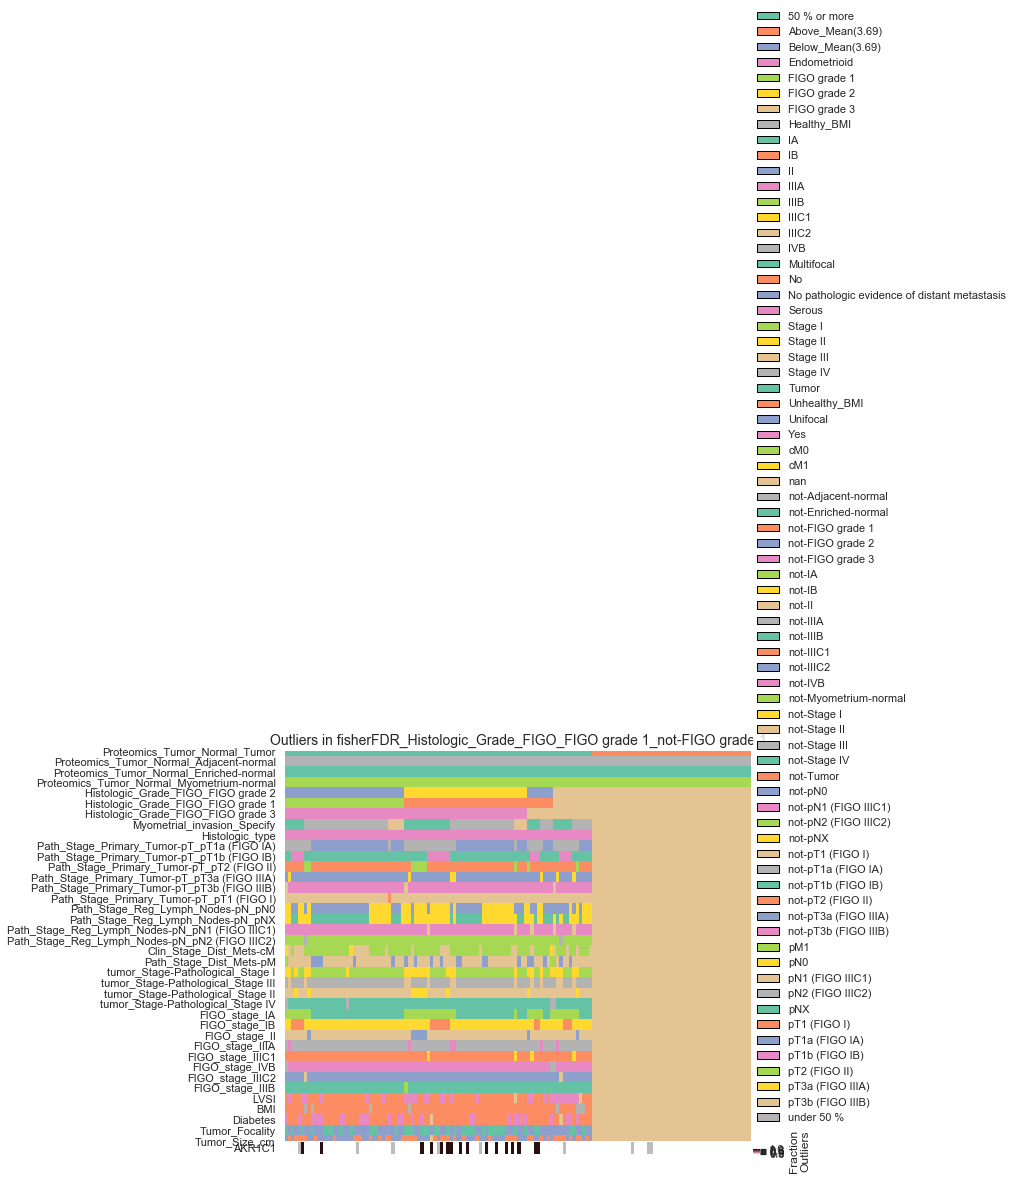

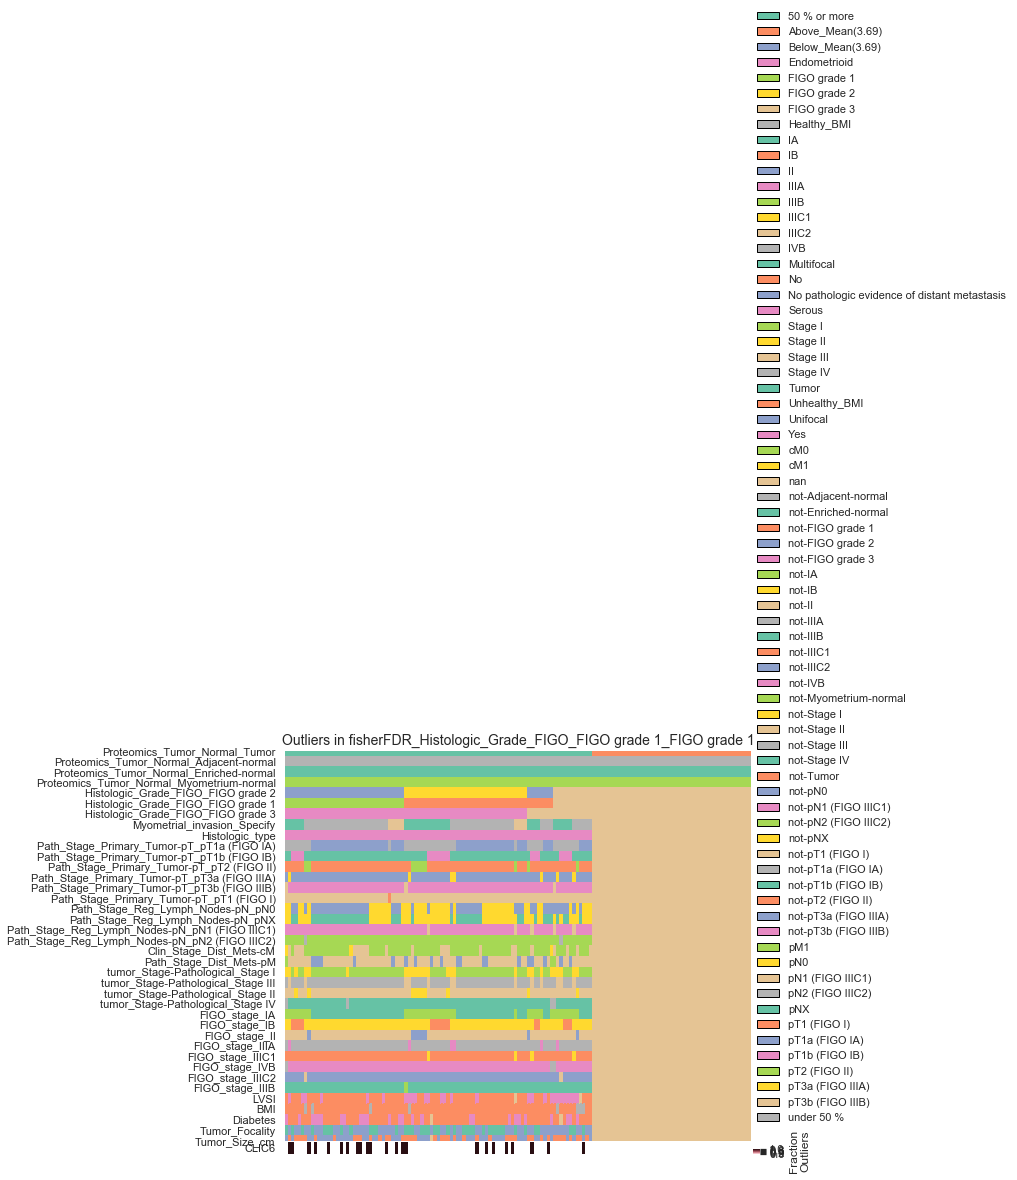

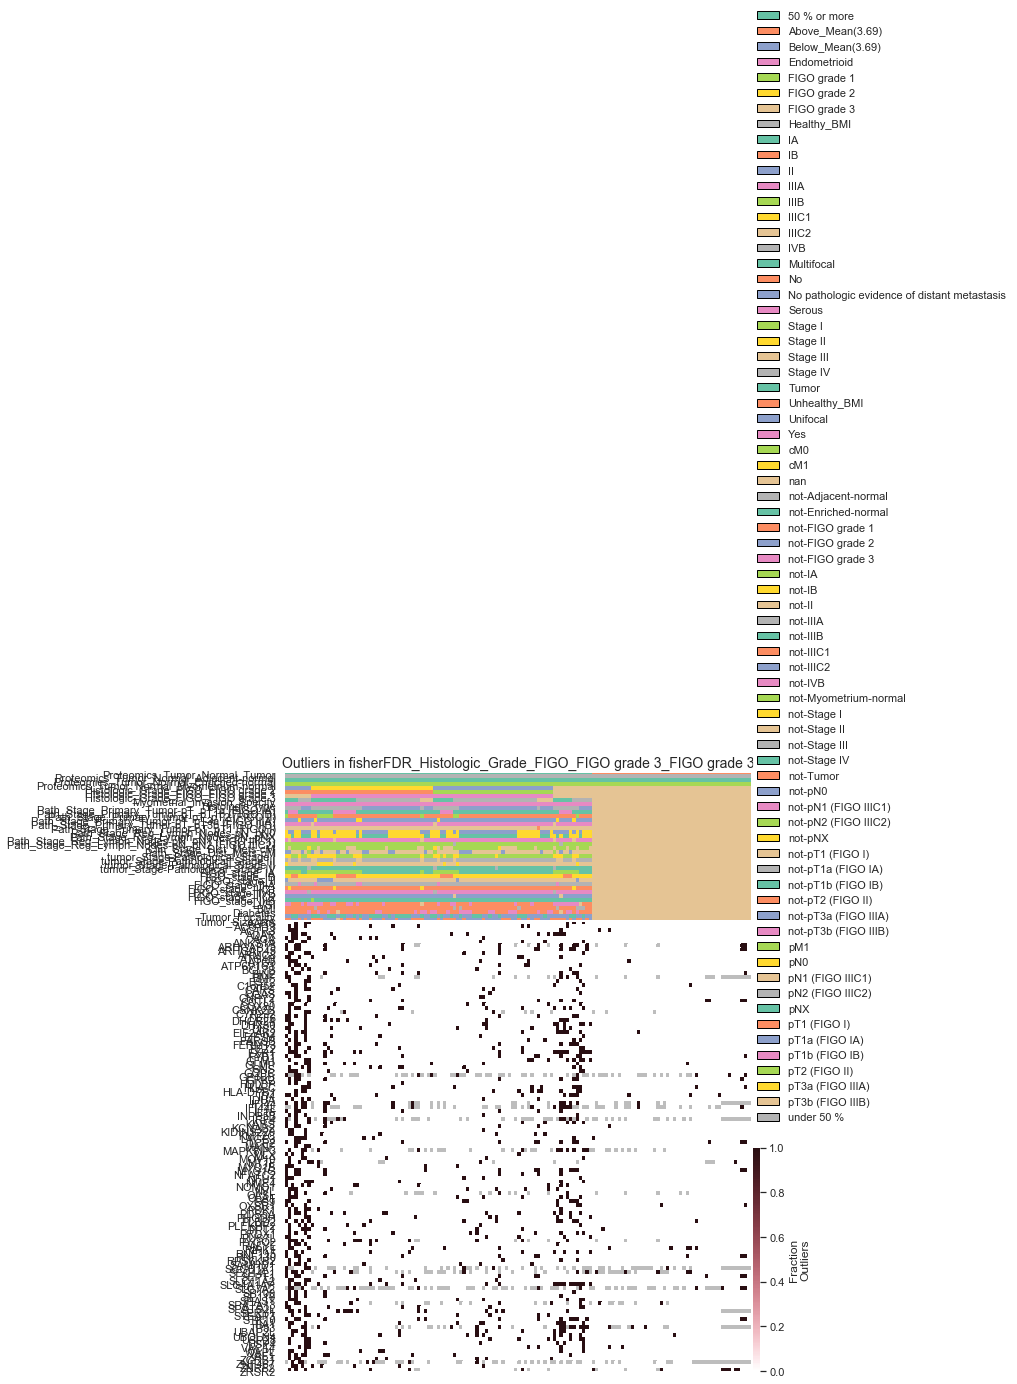

09/05/2019 14:07:16:WARNING:No significant genes at FDR 0.05 in fisherFDR_Myometrial_invasion_Specify_under 50 %


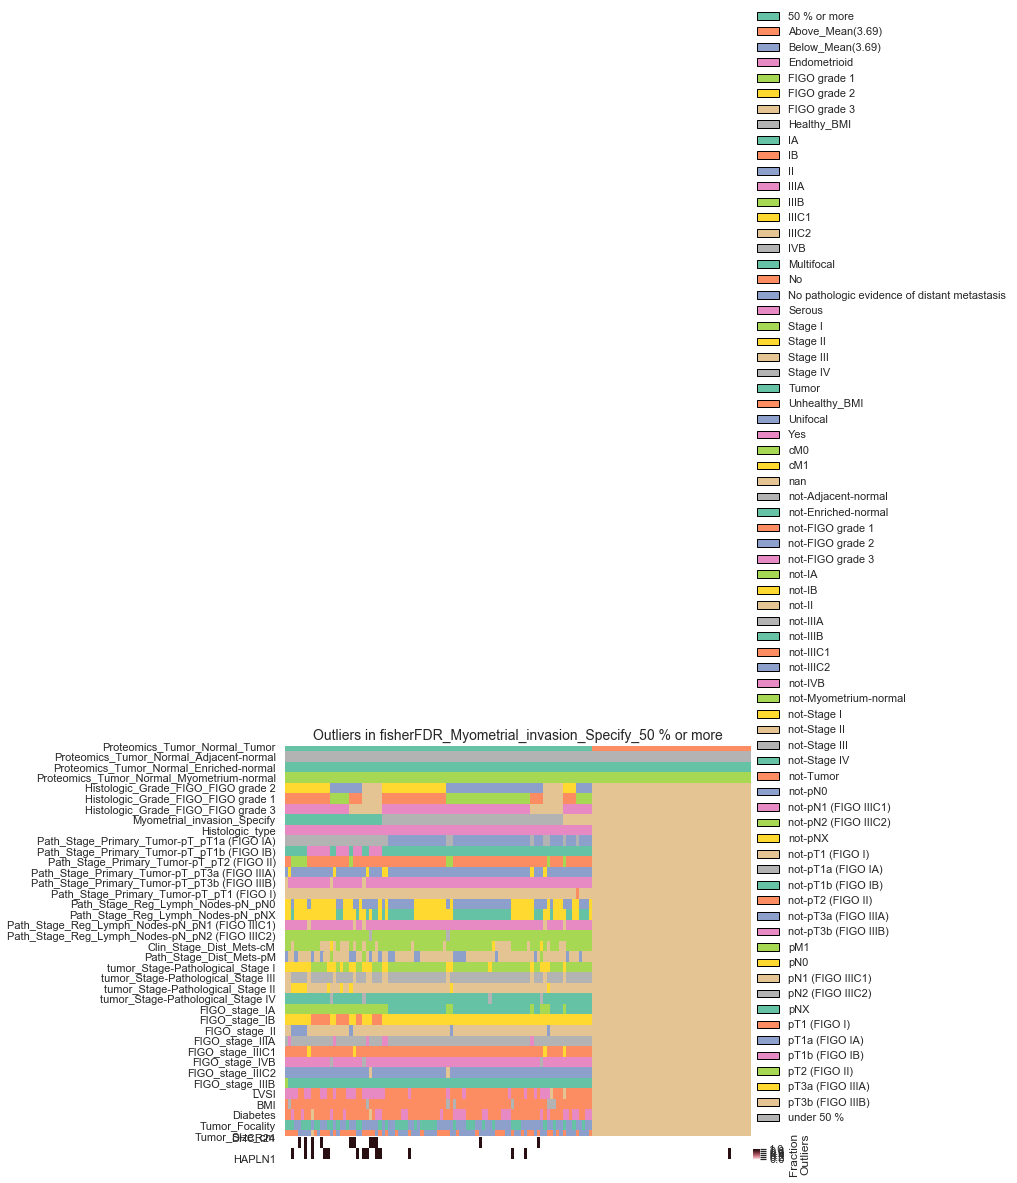

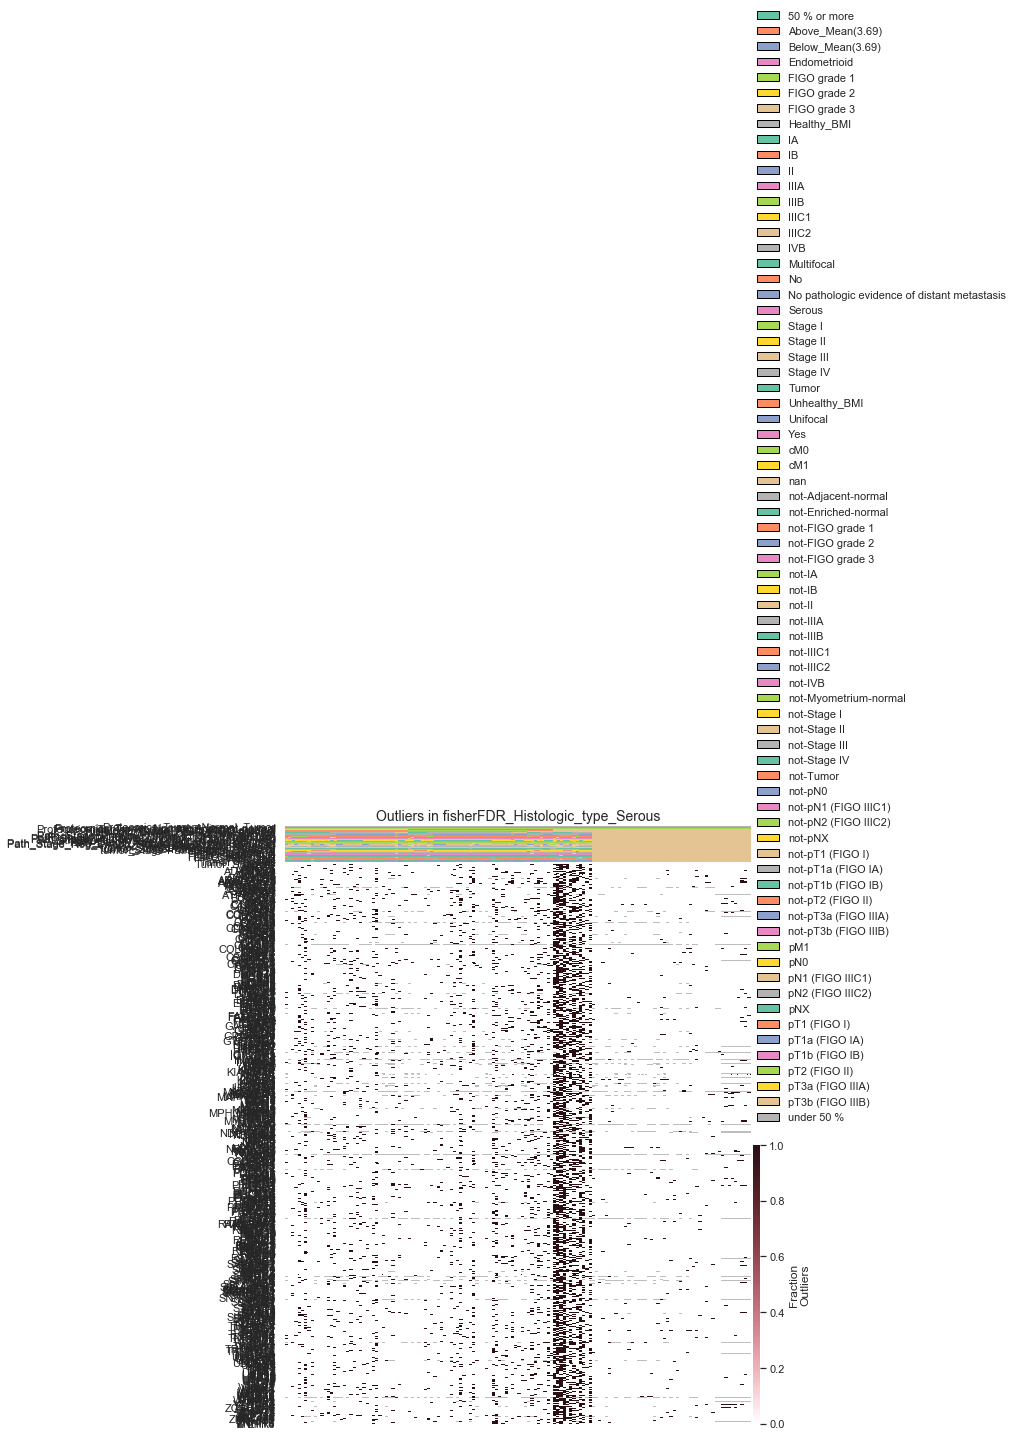

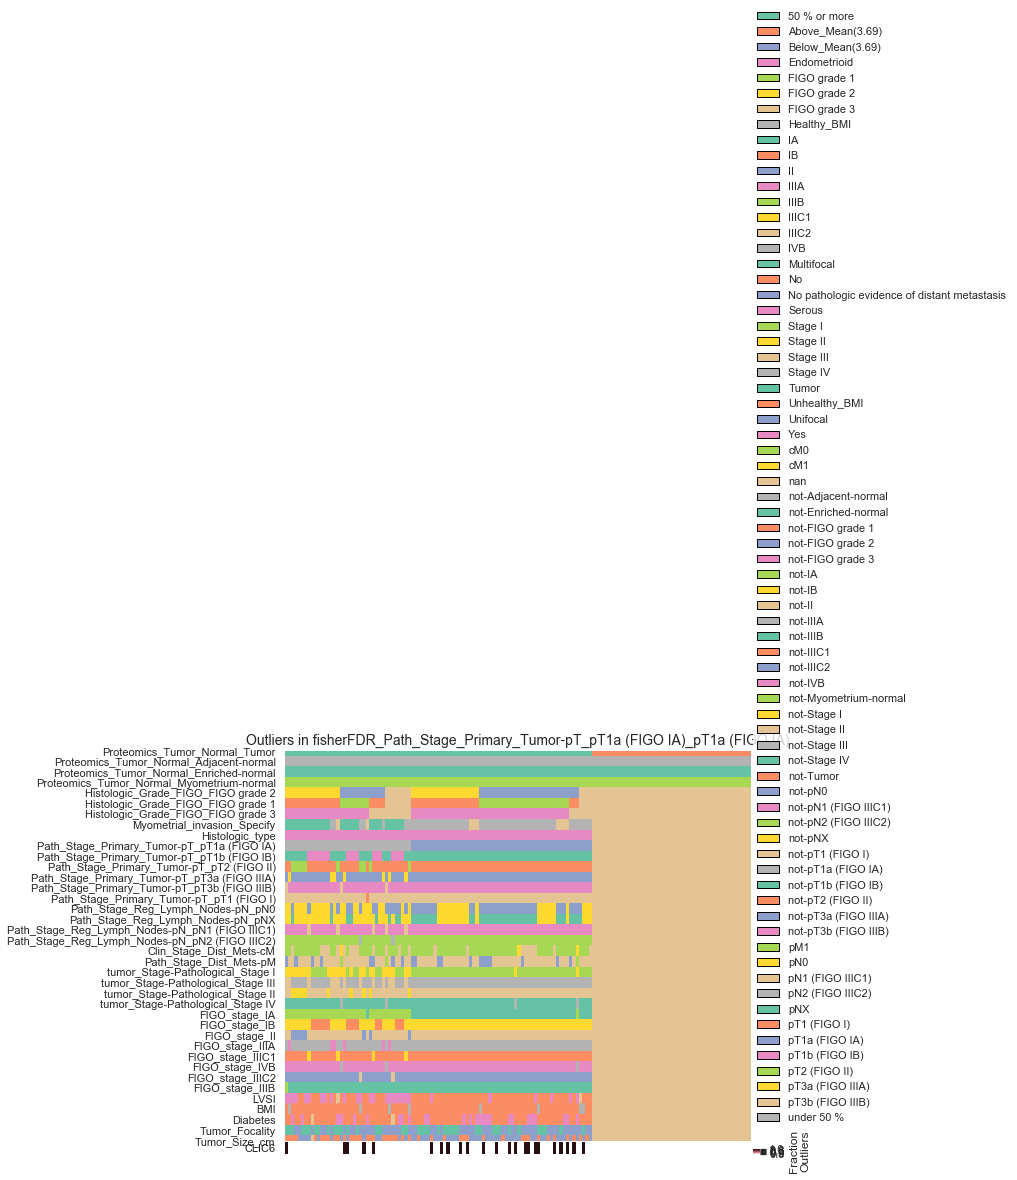

09/05/2019 14:07:45:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT1a (FIGO IA)_not-pT1a (FIGO IA)


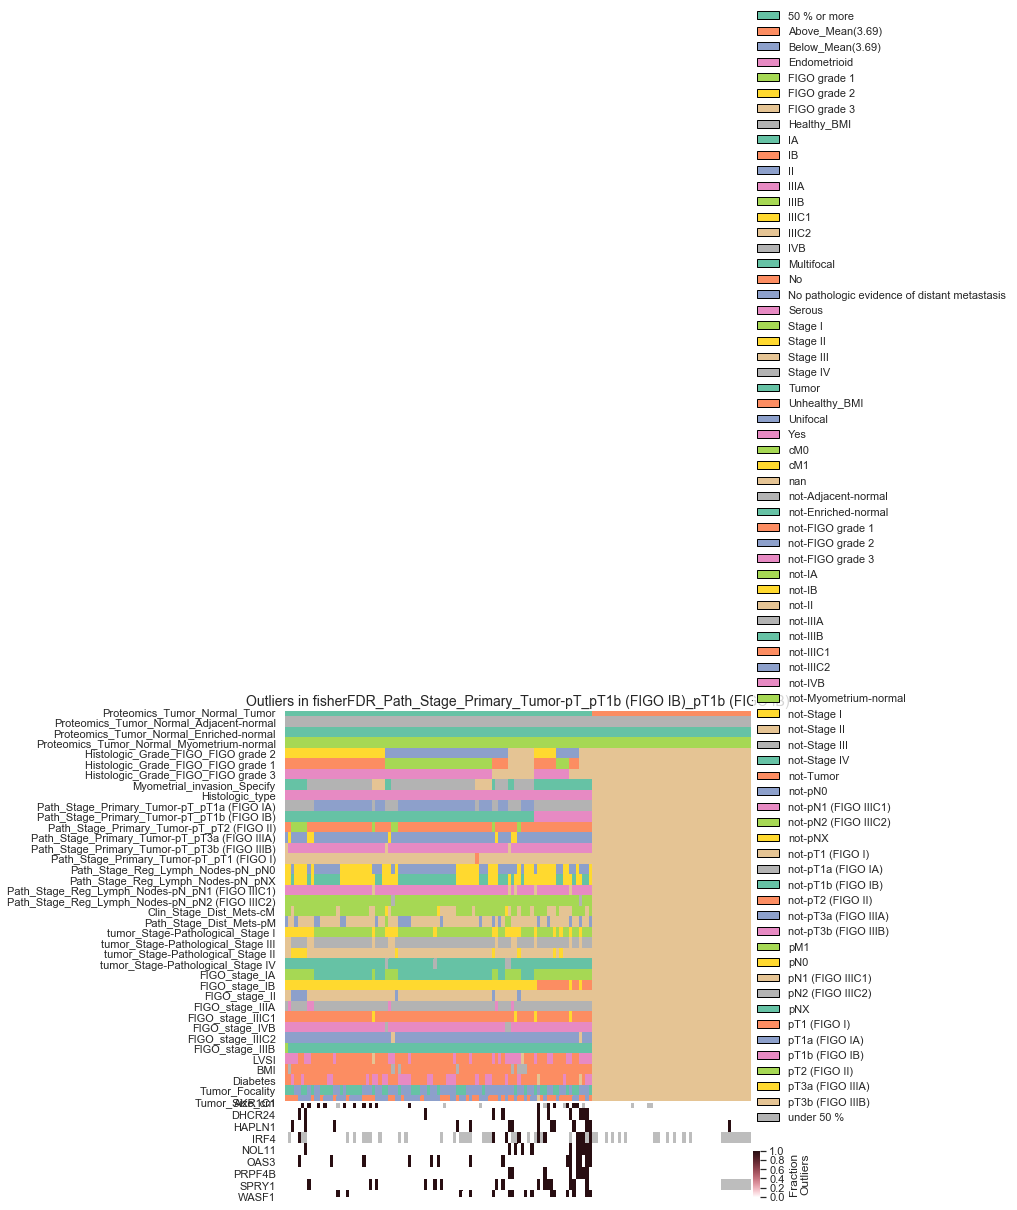

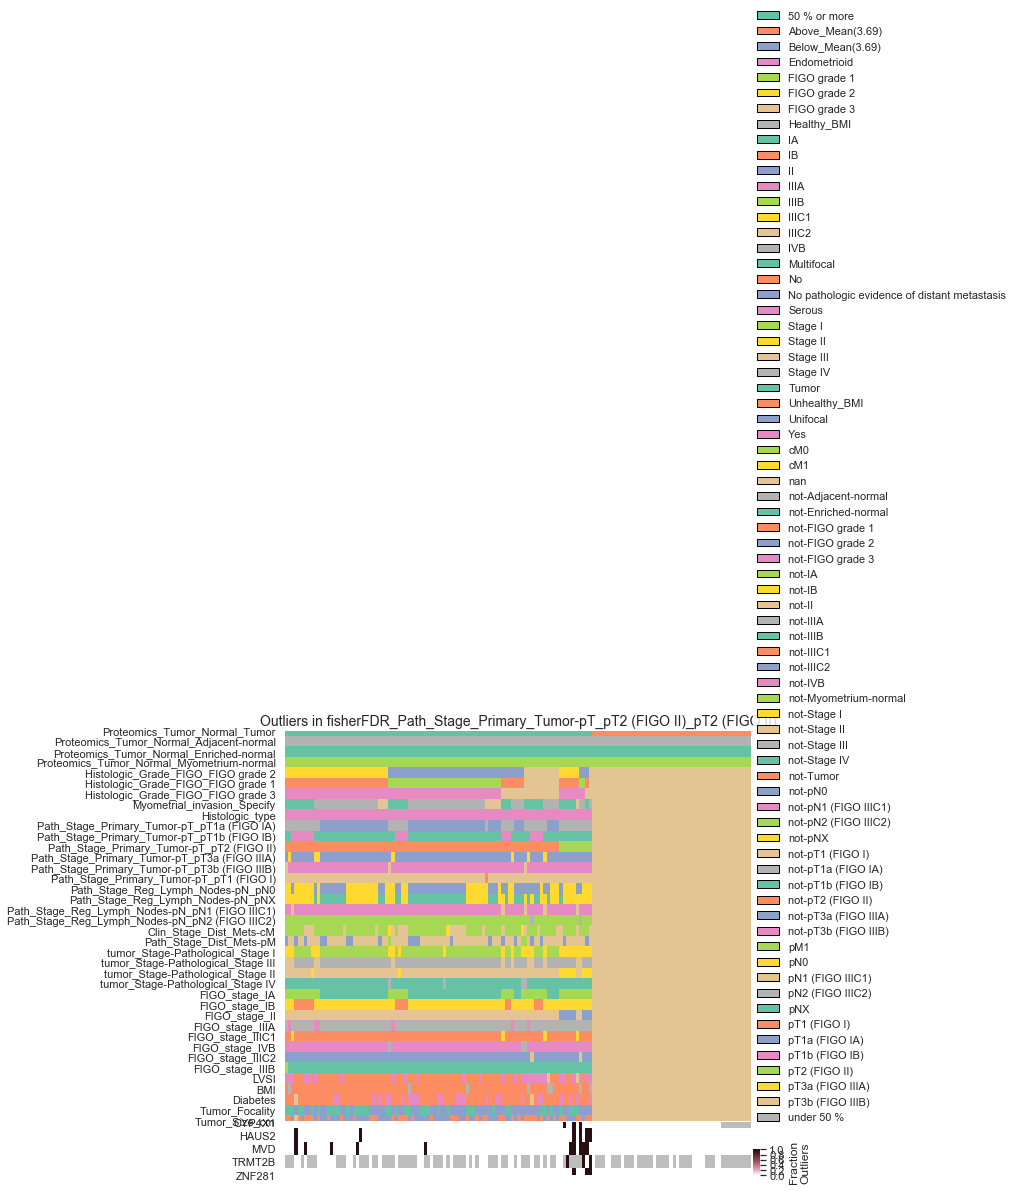

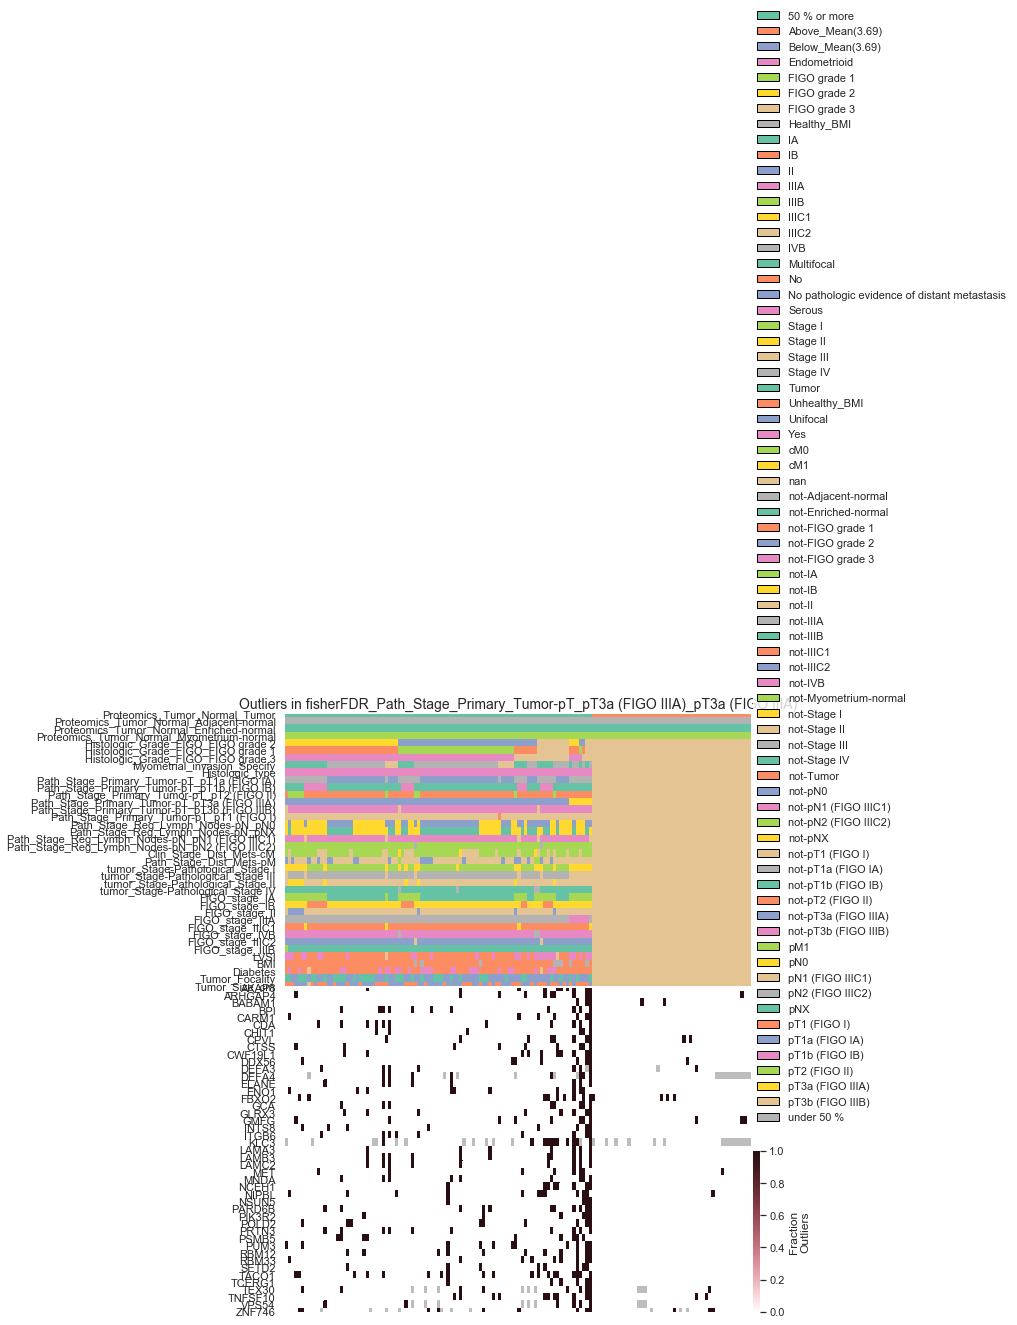

09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT3b (FIGO IIIB)_pT3b (FIGO IIIB)
09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN0_pN0
09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN1 (FIGO IIIC1)_pN1 (FIGO IIIC1)
09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN2 (FIGO IIIC2)_pN2 (FIGO IIIC2)
09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Clin_Stage_Dist_Mets-cM_cM1
09/05/2019 14:07:58:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_No pathologic evidence of distant metastasis
09/05/2019 14:07:59:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_pM1


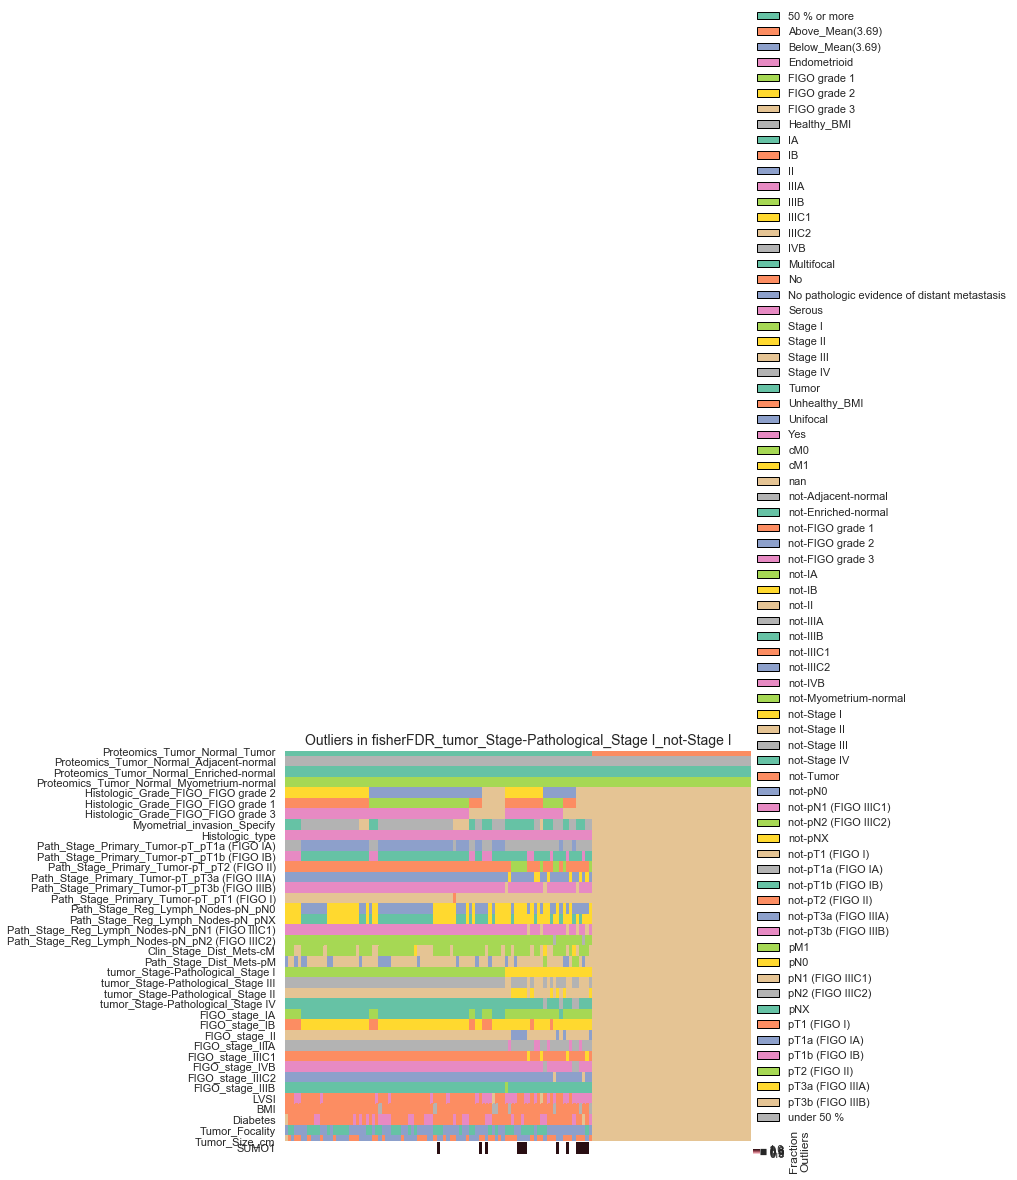

09/05/2019 14:08:02:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_Stage-Pathological_Stage III_Stage III
09/05/2019 14:08:02:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_Stage-Pathological_Stage II_Stage II


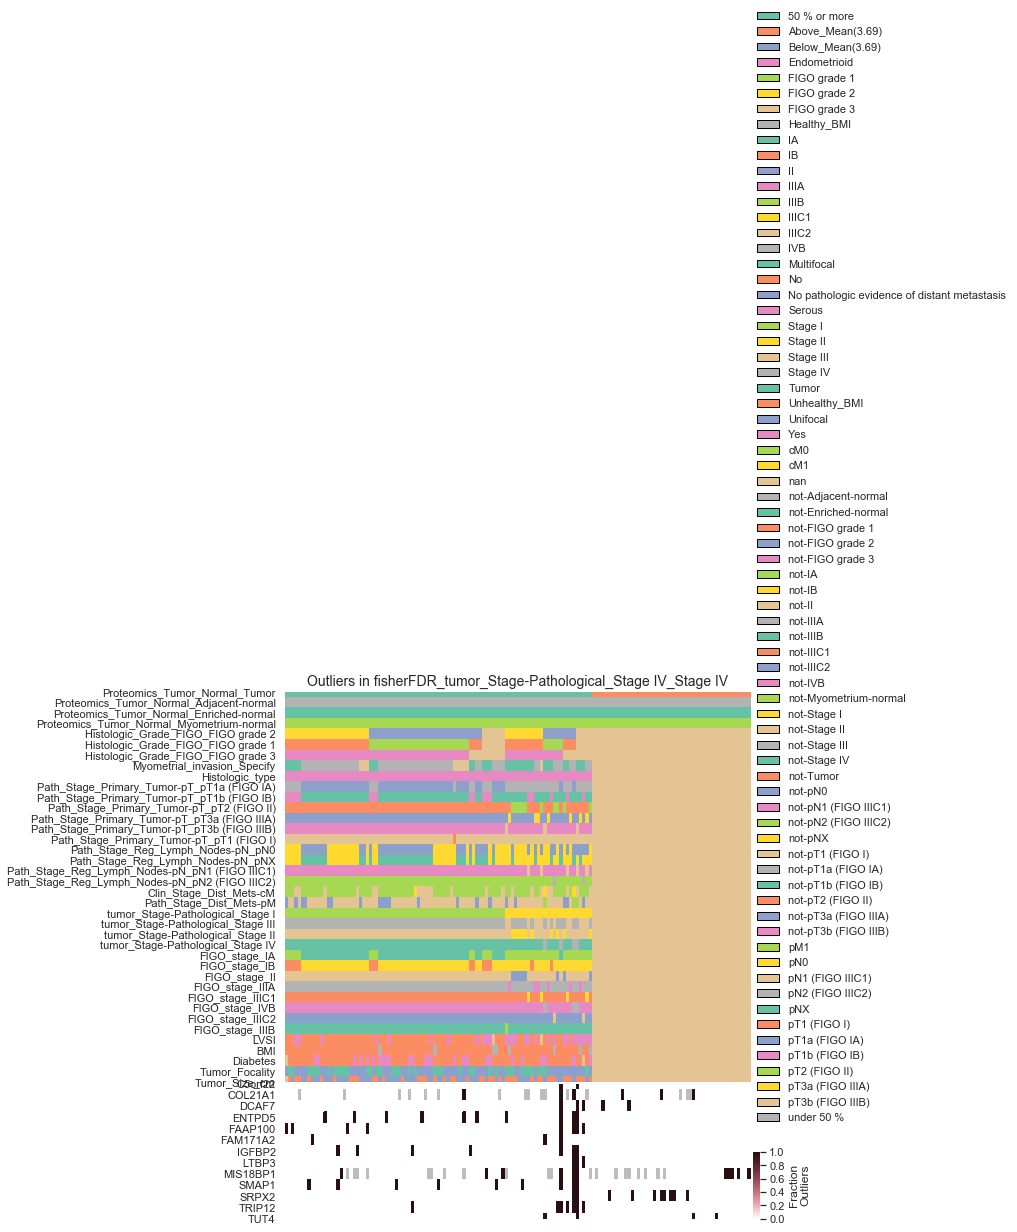

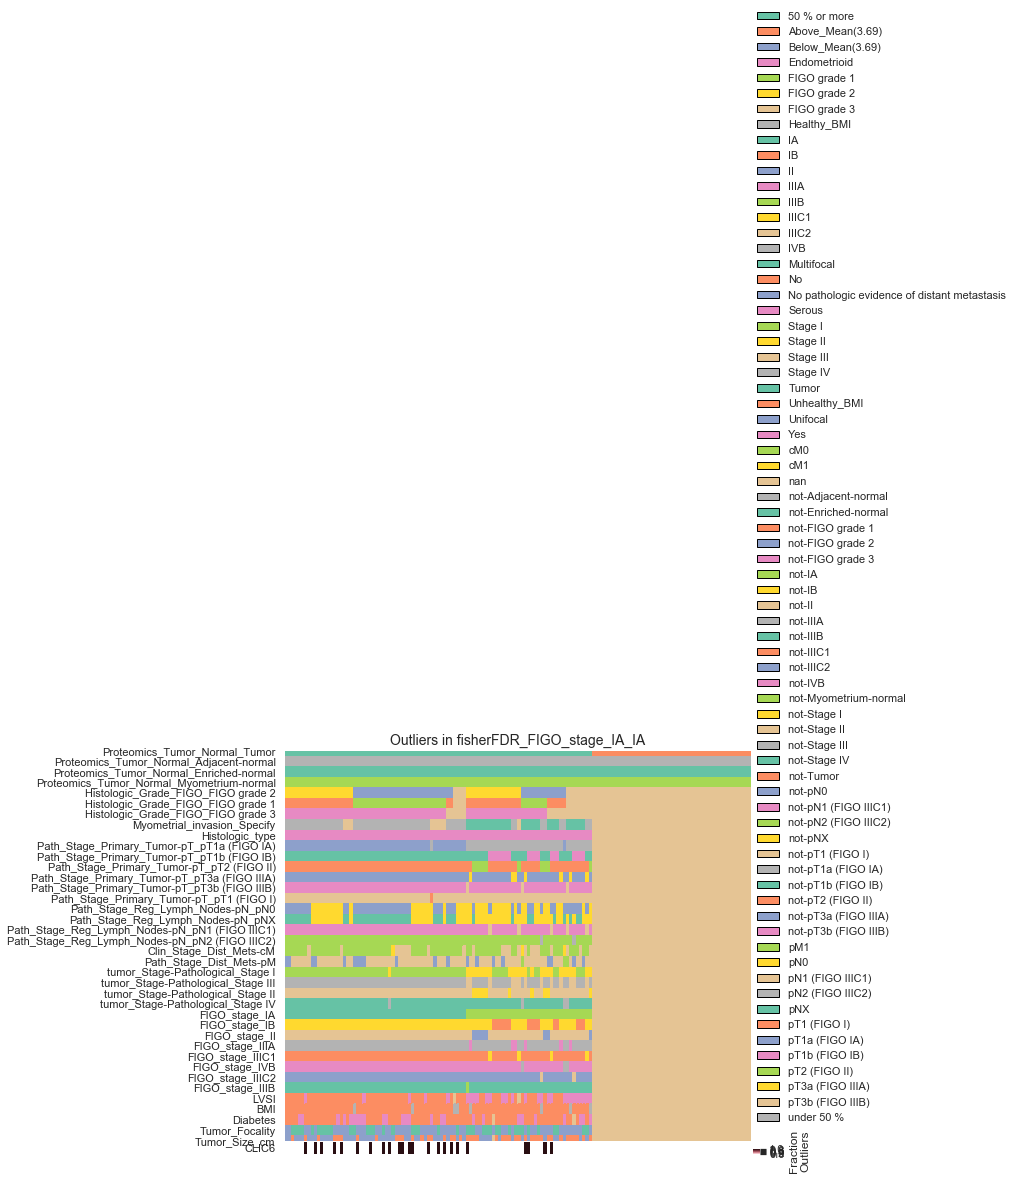

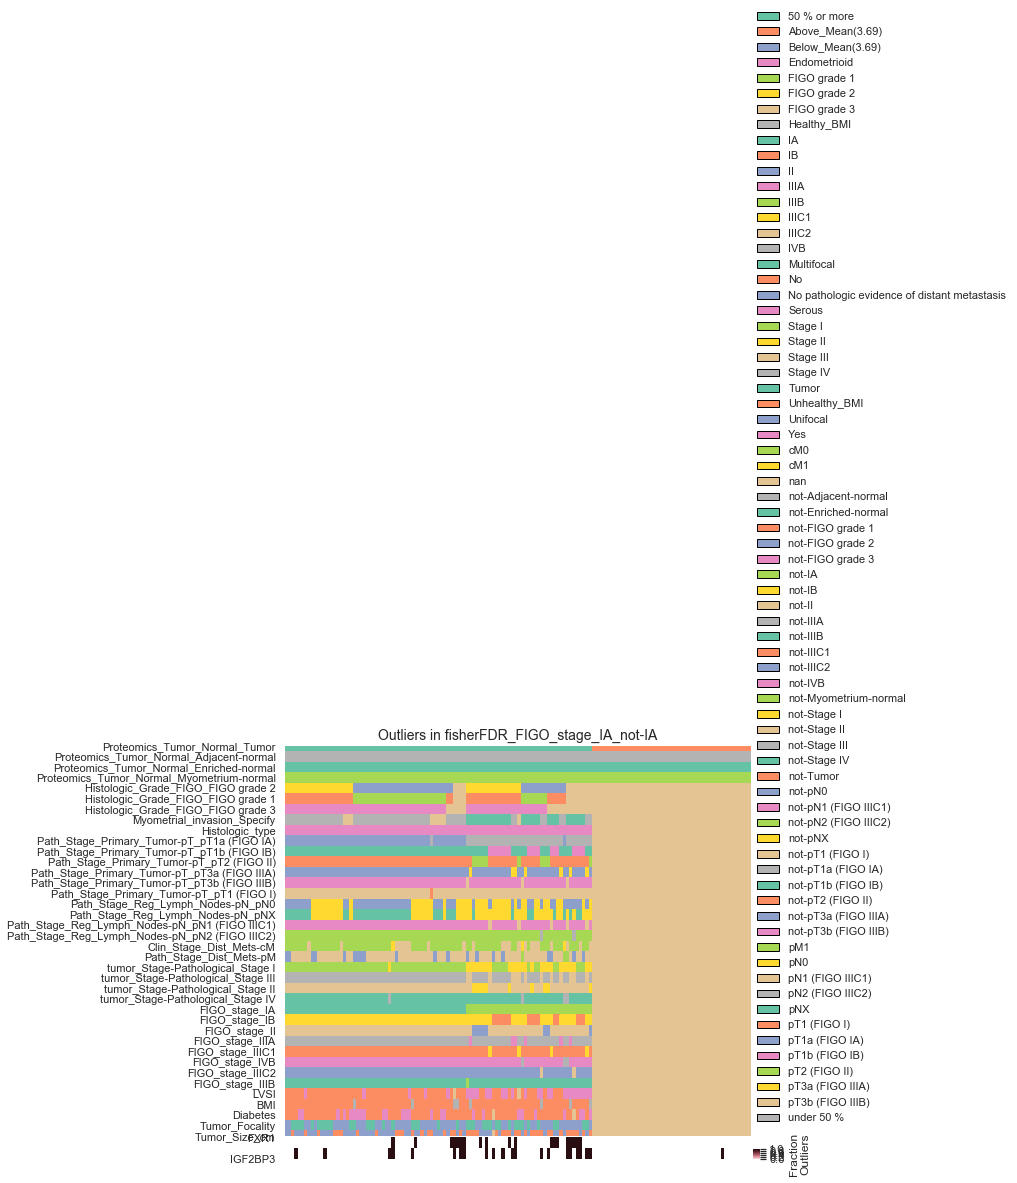

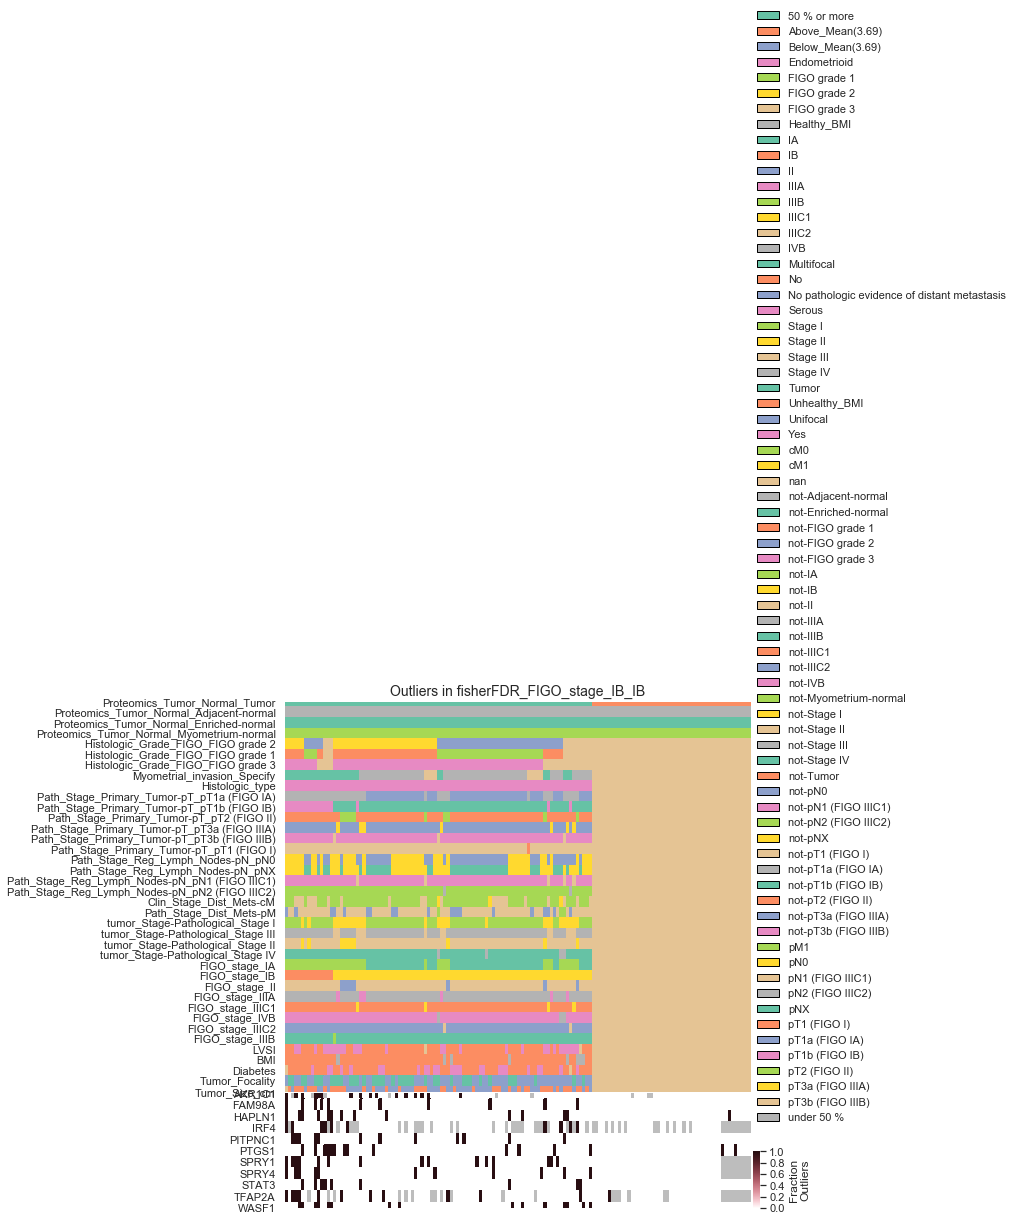

09/05/2019 14:08:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_II_II
09/05/2019 14:08:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIA_IIIA
09/05/2019 14:08:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIC1_IIIC1
09/05/2019 14:08:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IVB_IVB
09/05/2019 14:08:19:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIC2_IIIC2


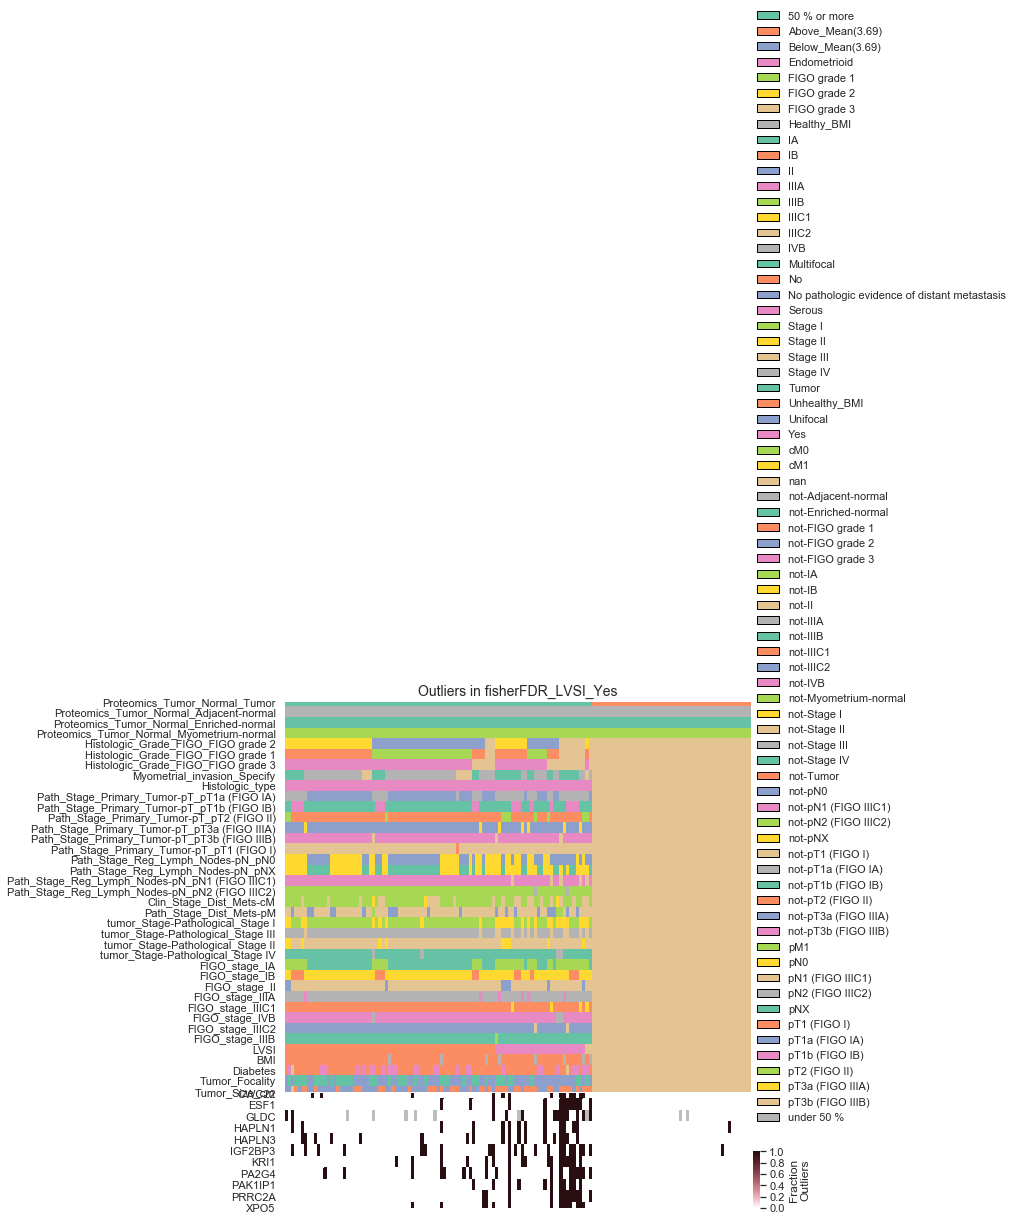

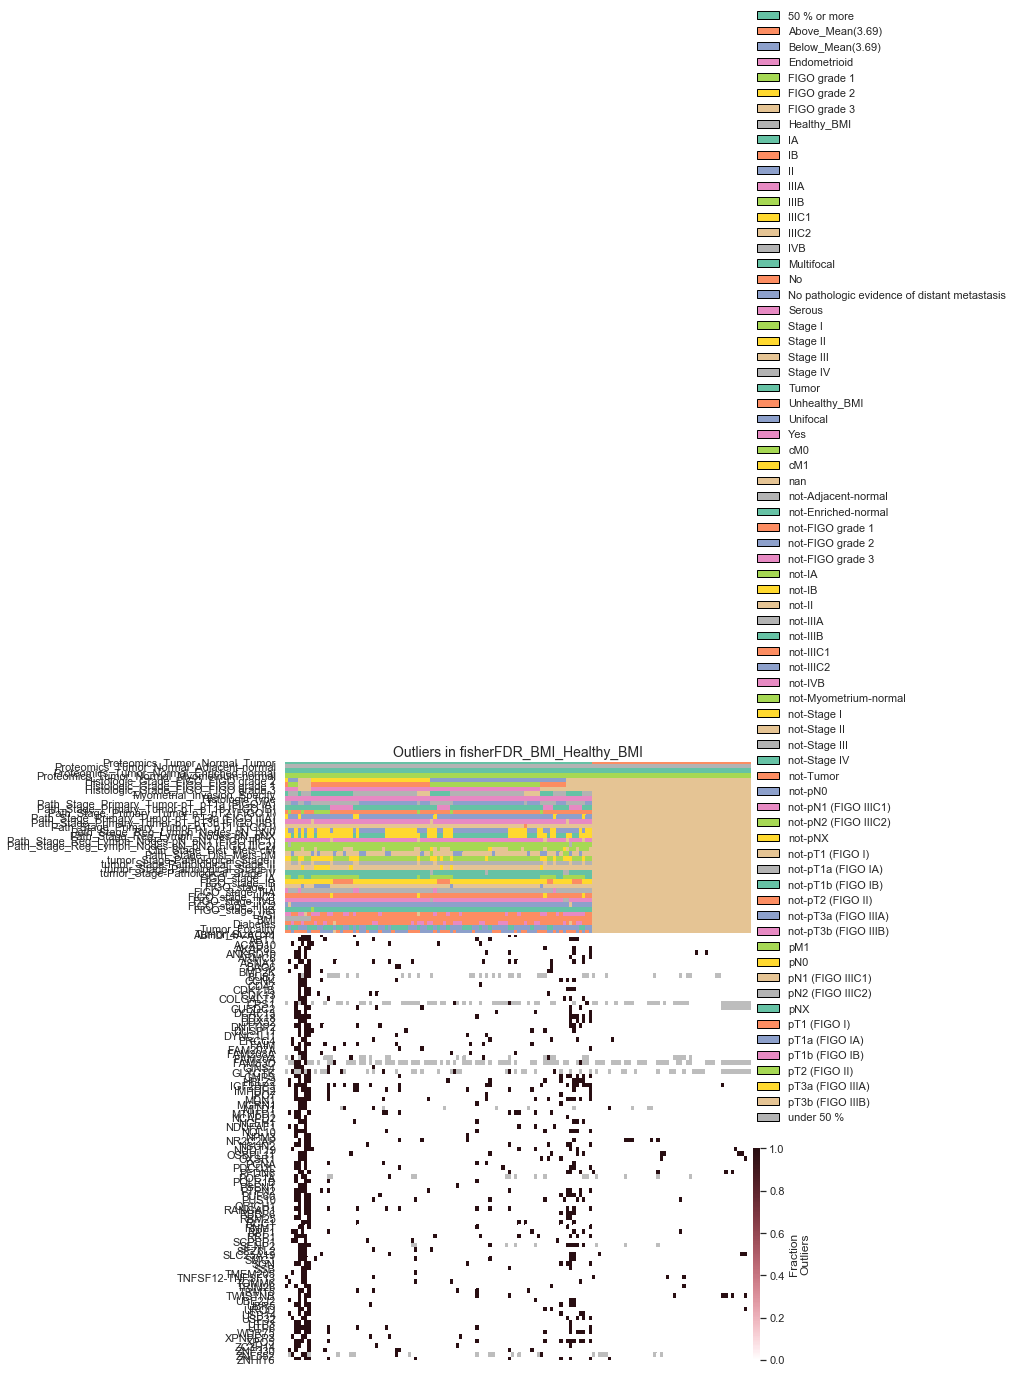

09/05/2019 14:08:31:WARNING:No significant genes at FDR 0.05 in fisherFDR_Diabetes_Yes


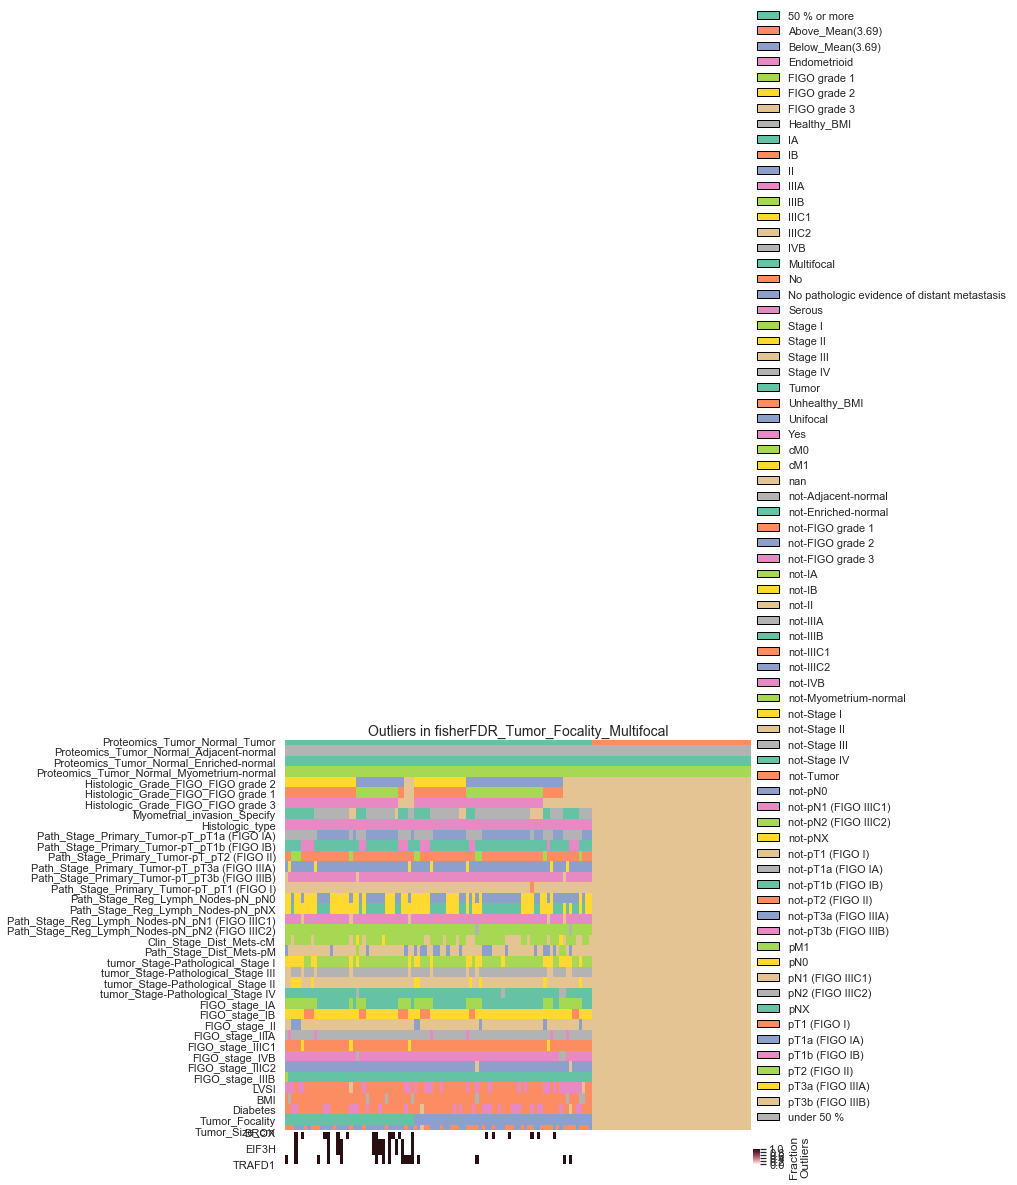

09/05/2019 14:08:36:WARNING:No significant genes at FDR 0.05 in fisherFDR_Tumor_Size_cm_Above_Mean(3.69)


In [15]:
#Deva package visualization
for col in qvalues.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues.df,
    col_of_interest=col,
    vis_table=outliers.frac_table)
    
    plt.show()
    plt.close()

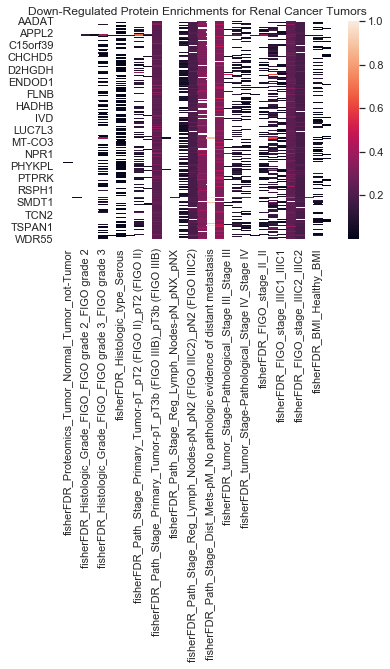

In [16]:
ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

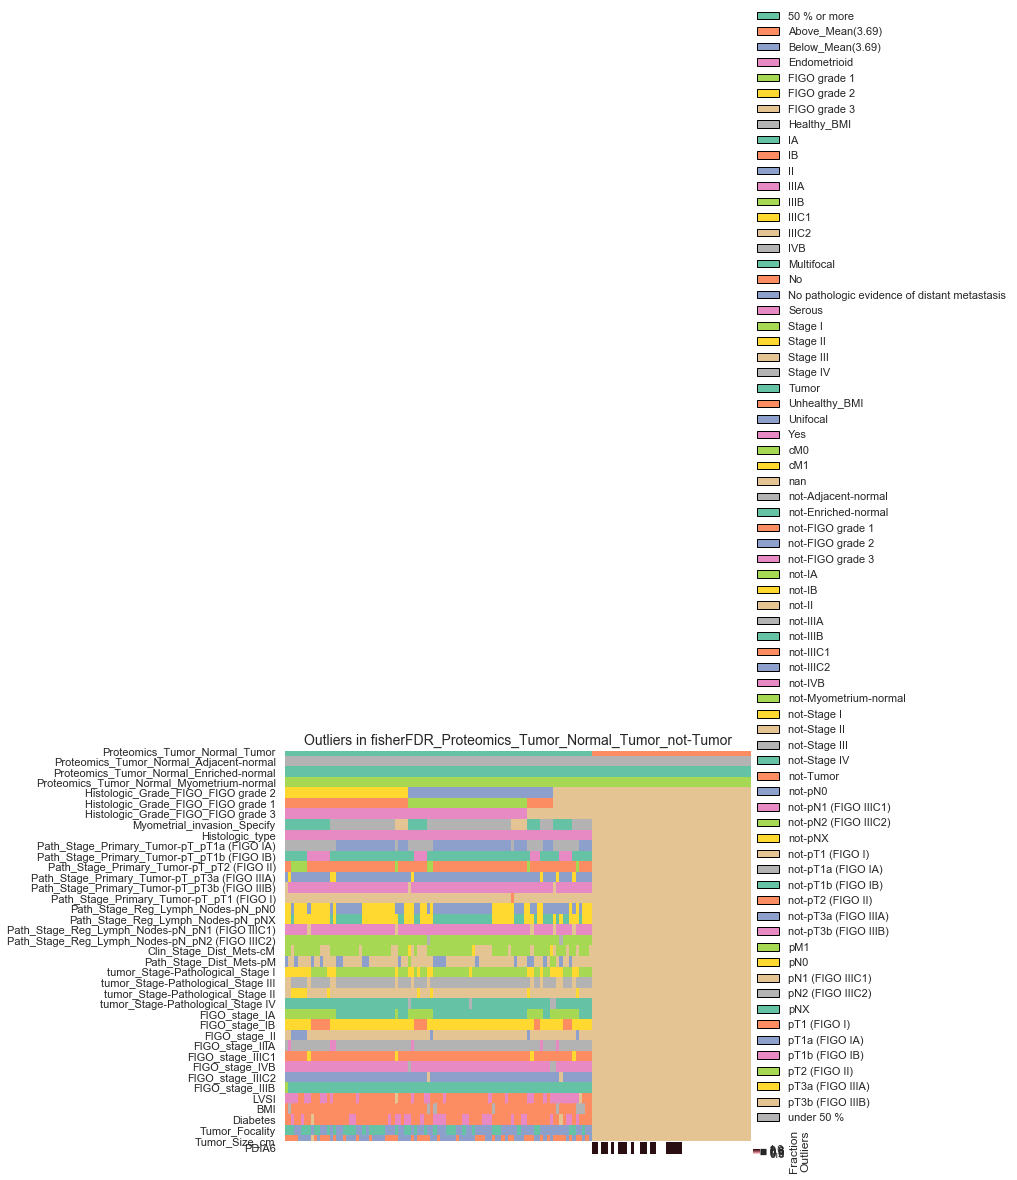

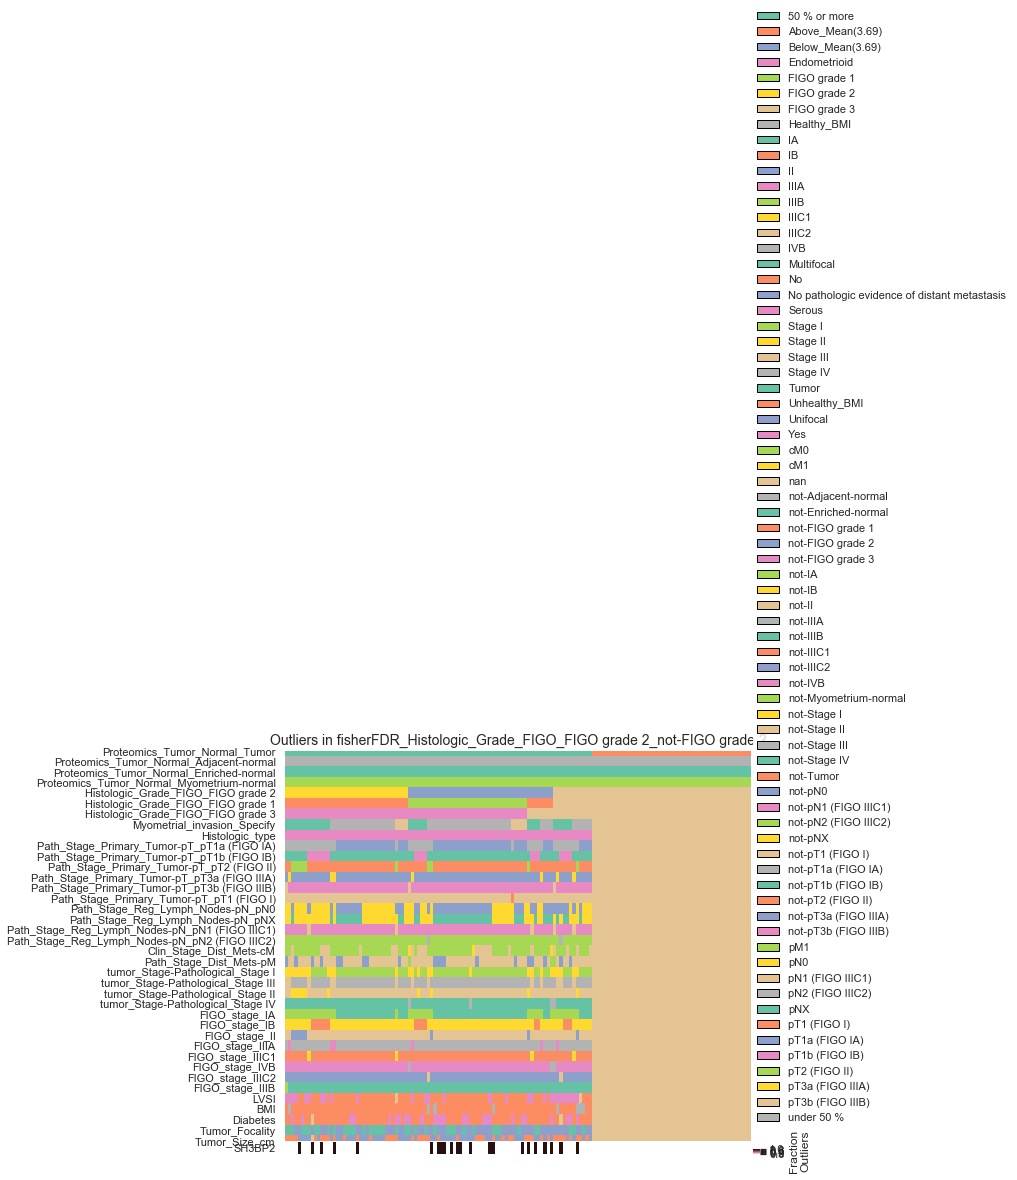

09/05/2019 14:08:44:WARNING:No significant genes at FDR 0.05 in fisherFDR_Histologic_Grade_FIGO_FIGO grade 2_FIGO grade 2


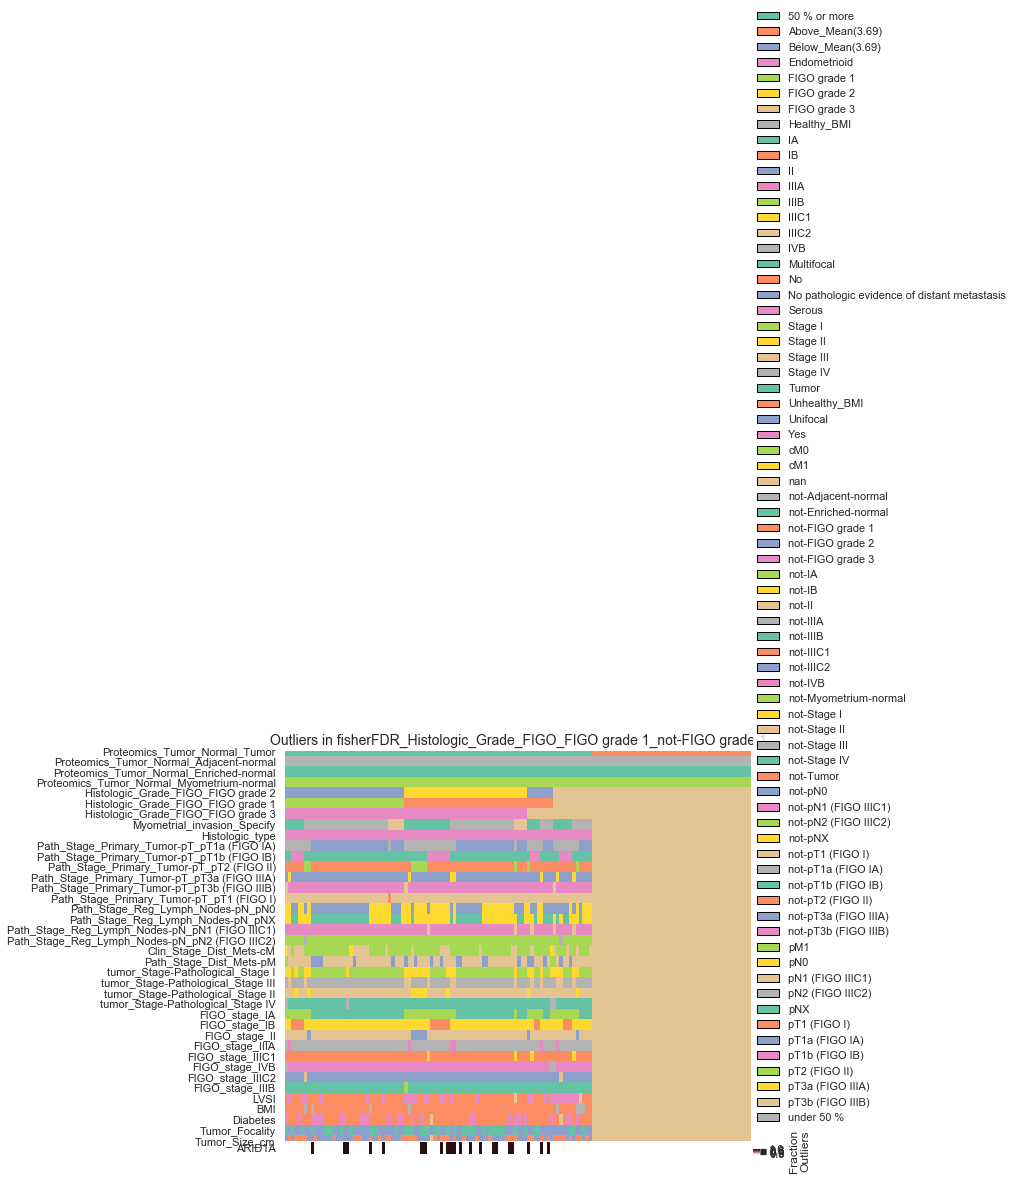

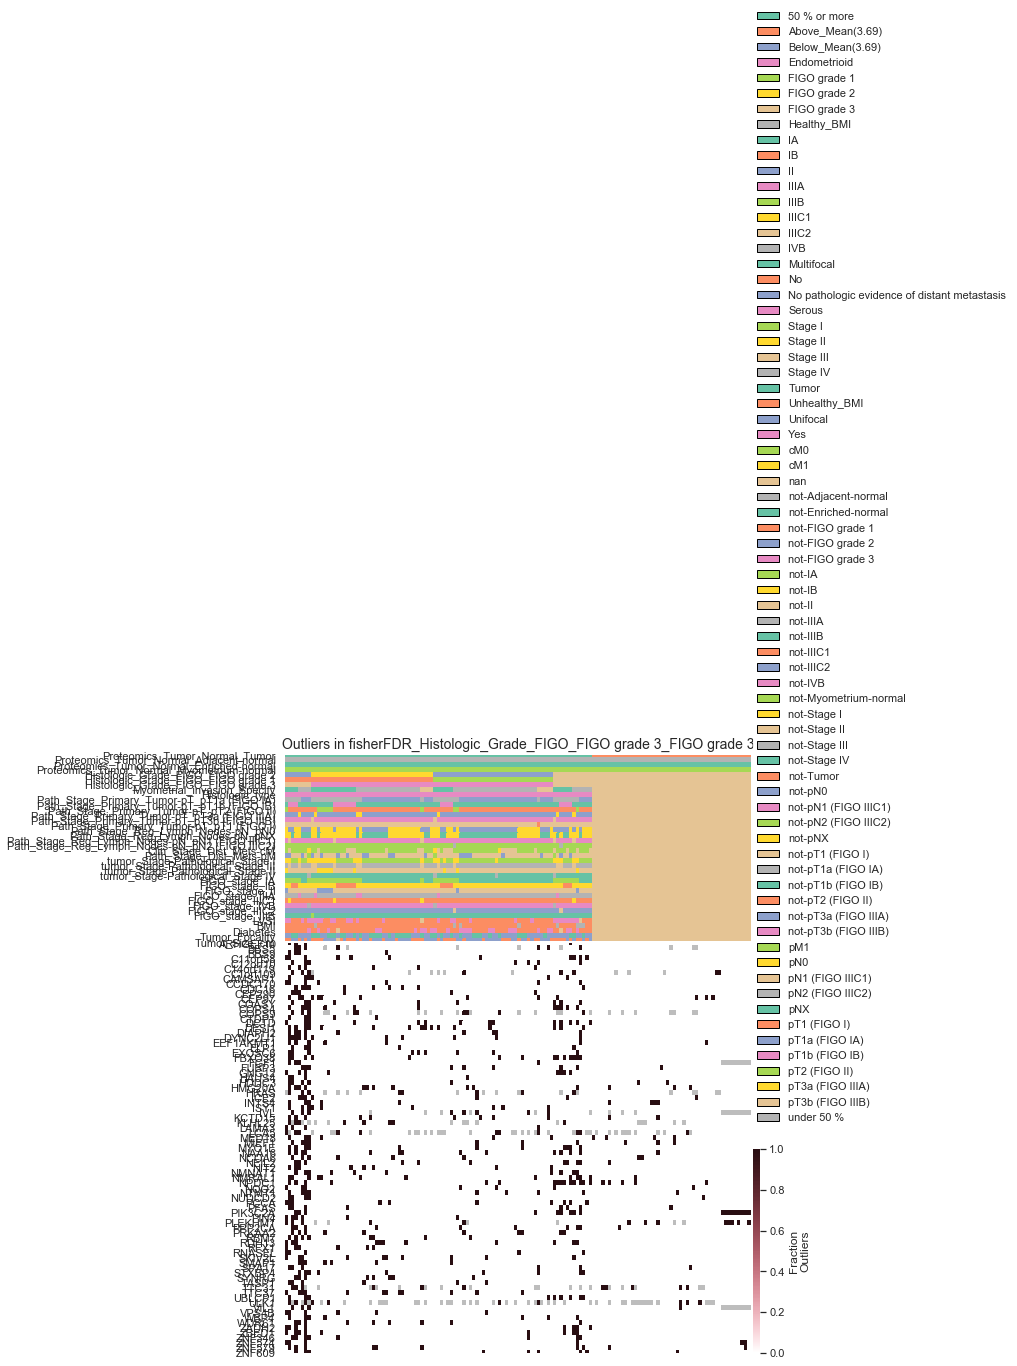

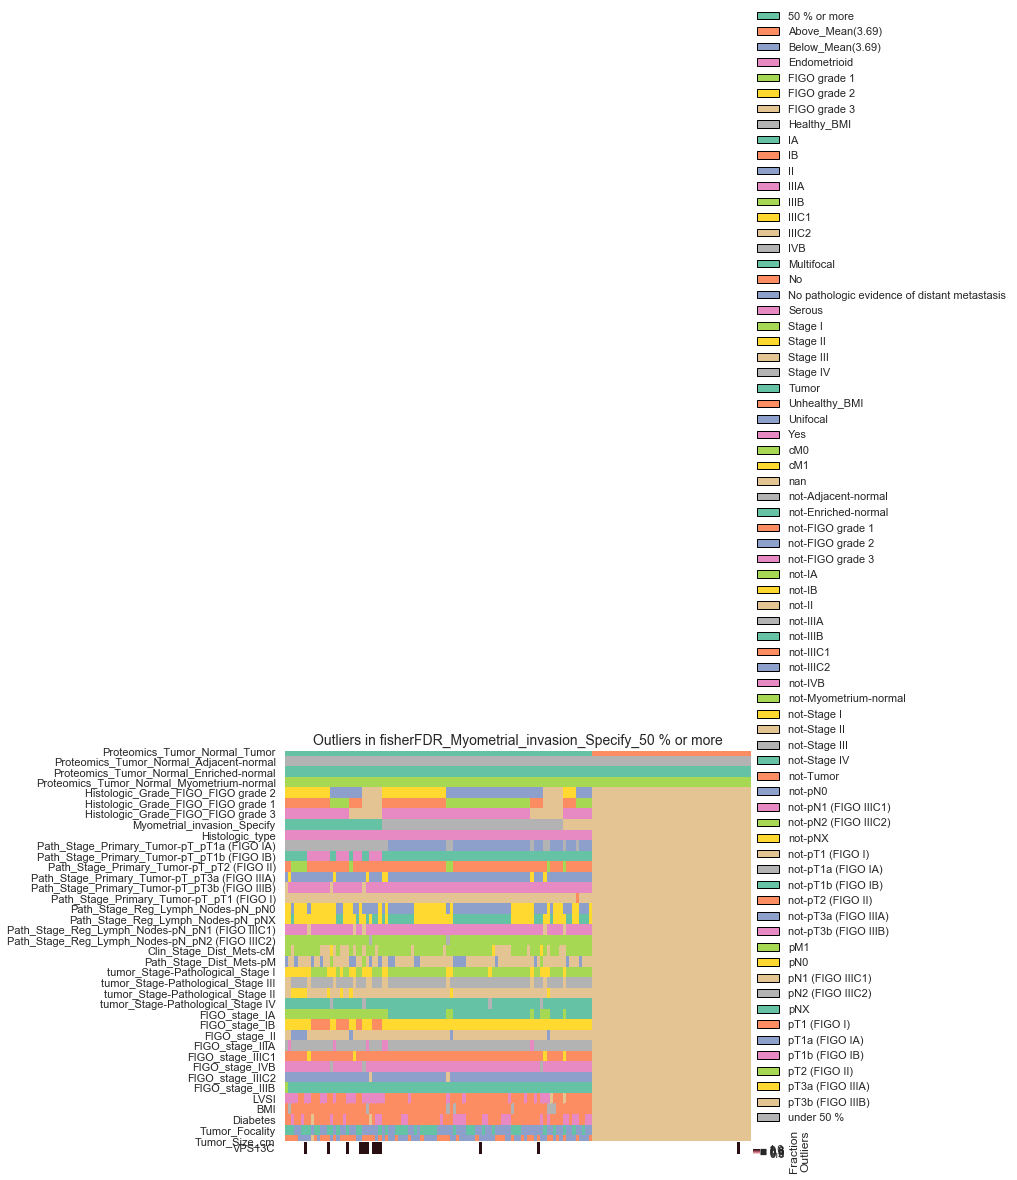

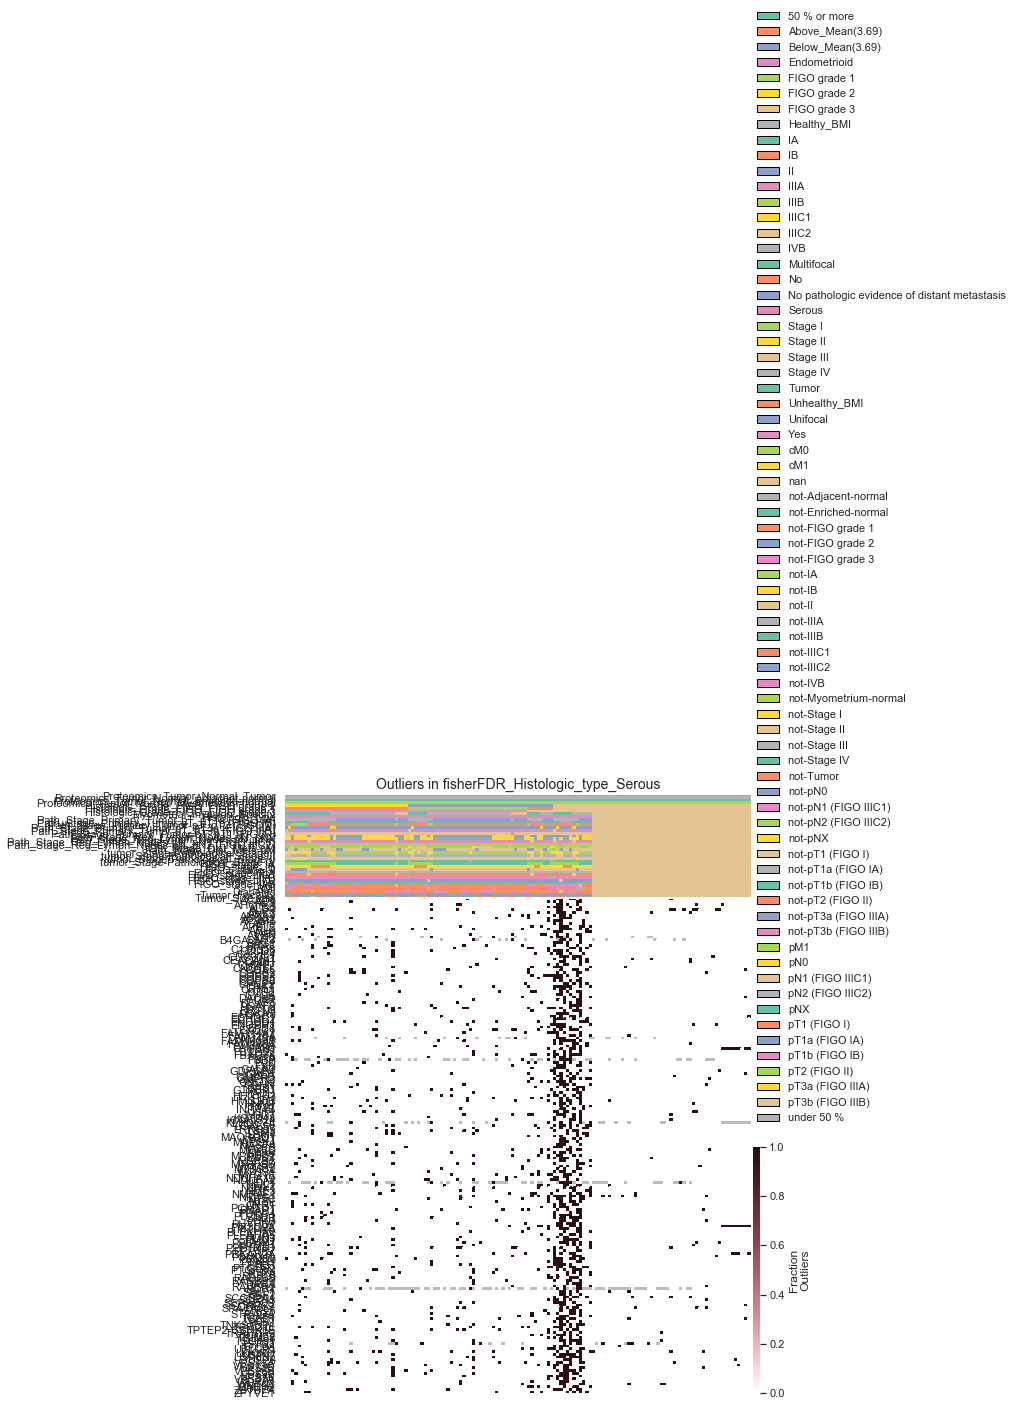

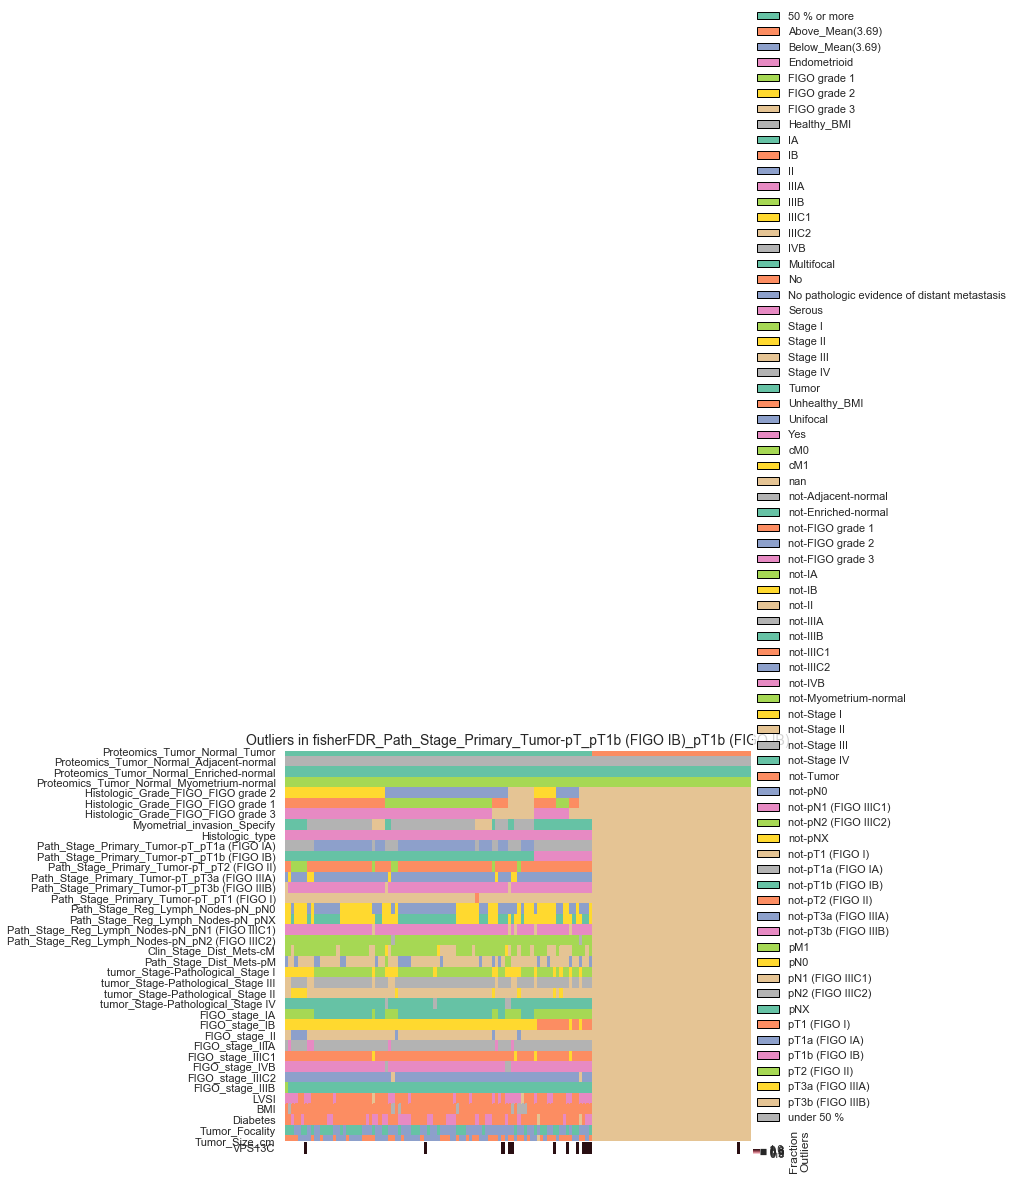

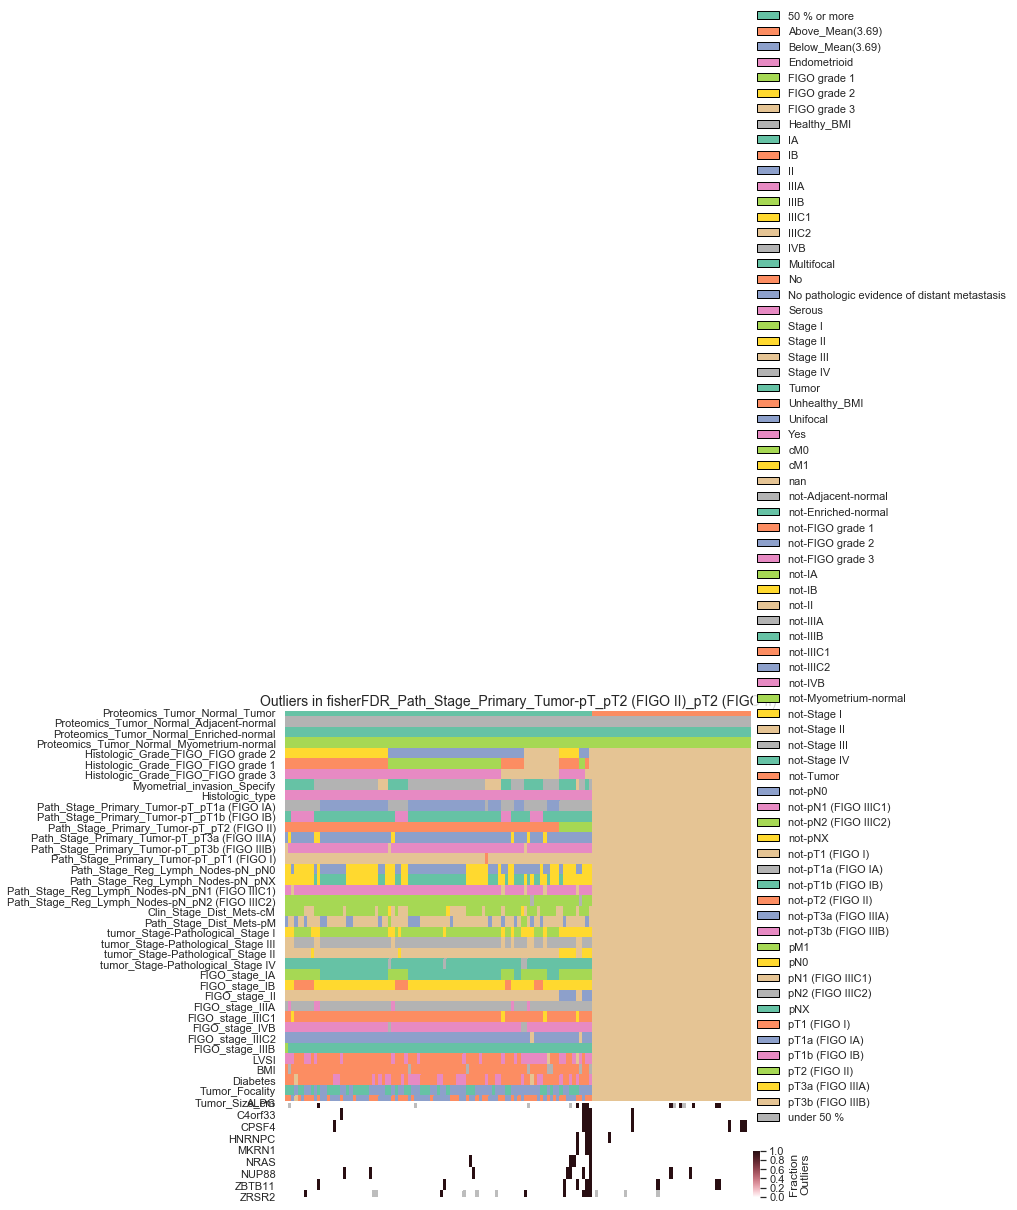

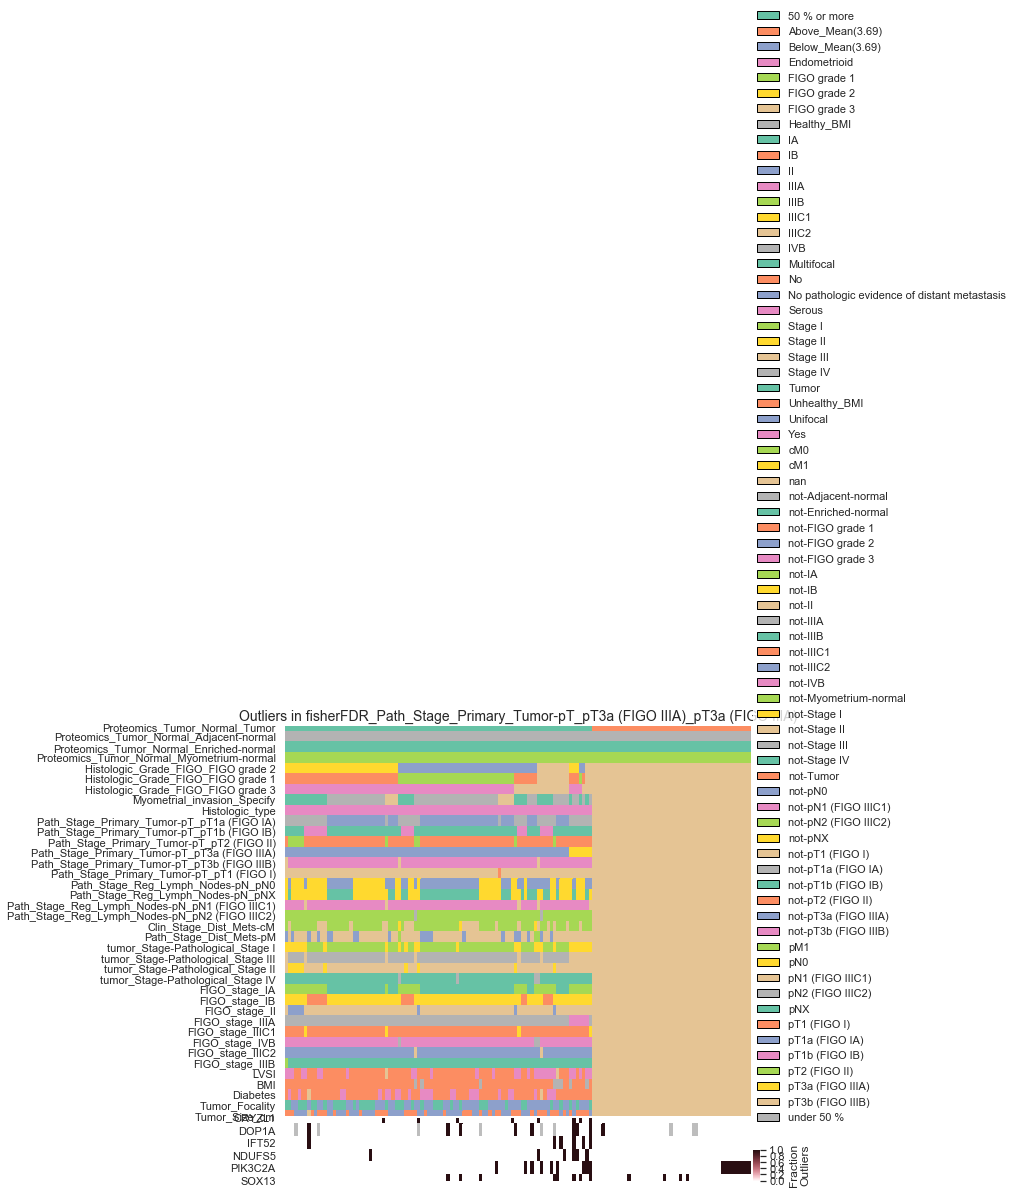

09/05/2019 14:09:23:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Primary_Tumor-pT_pT3b (FIGO IIIB)_pT3b (FIGO IIIB)
09/05/2019 14:09:23:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN0_pN0
09/05/2019 14:09:23:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pNX_pNX


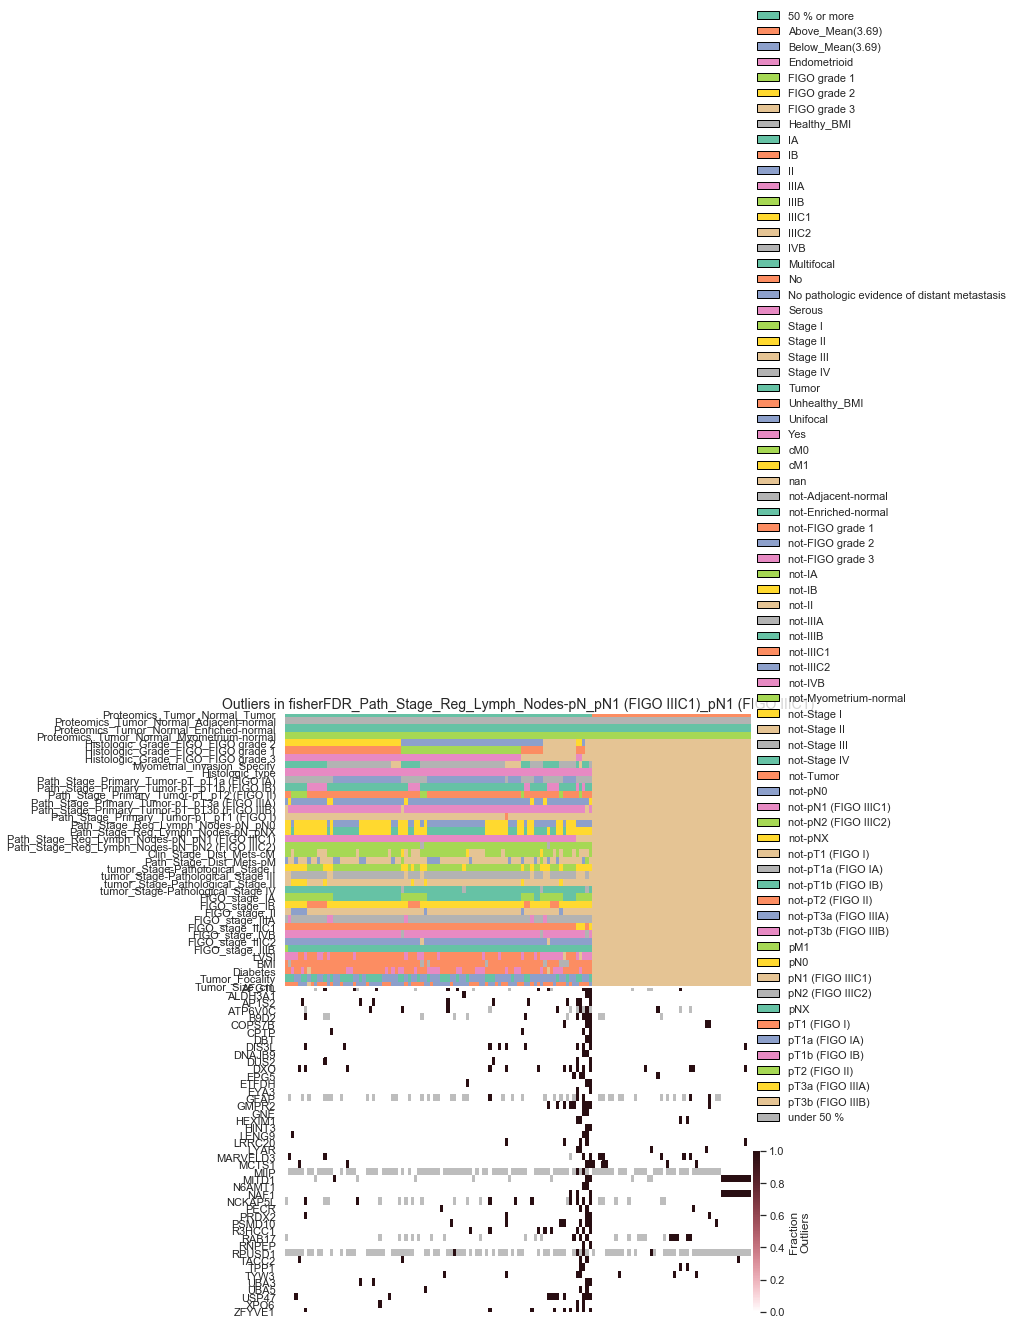

09/05/2019 14:09:29:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Reg_Lymph_Nodes-pN_pN2 (FIGO IIIC2)_pN2 (FIGO IIIC2)
09/05/2019 14:09:29:WARNING:No significant genes at FDR 0.05 in fisherFDR_Clin_Stage_Dist_Mets-cM_cM1
09/05/2019 14:09:29:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_No pathologic evidence of distant metastasis
09/05/2019 14:09:29:WARNING:No significant genes at FDR 0.05 in fisherFDR_Path_Stage_Dist_Mets-pM_pM1


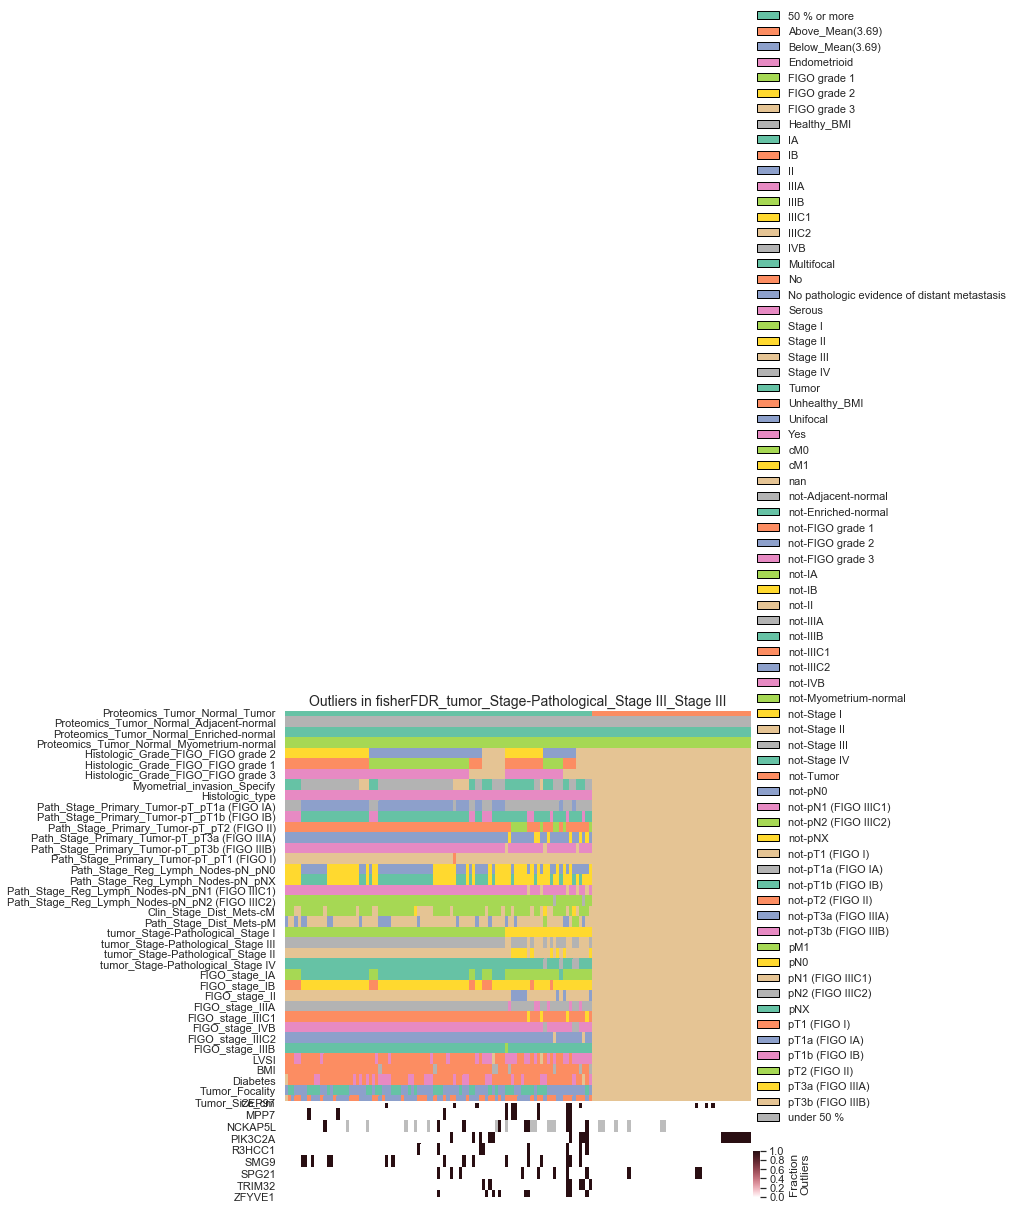

09/05/2019 14:09:36:WARNING:No significant genes at FDR 0.05 in fisherFDR_tumor_Stage-Pathological_Stage II_Stage II


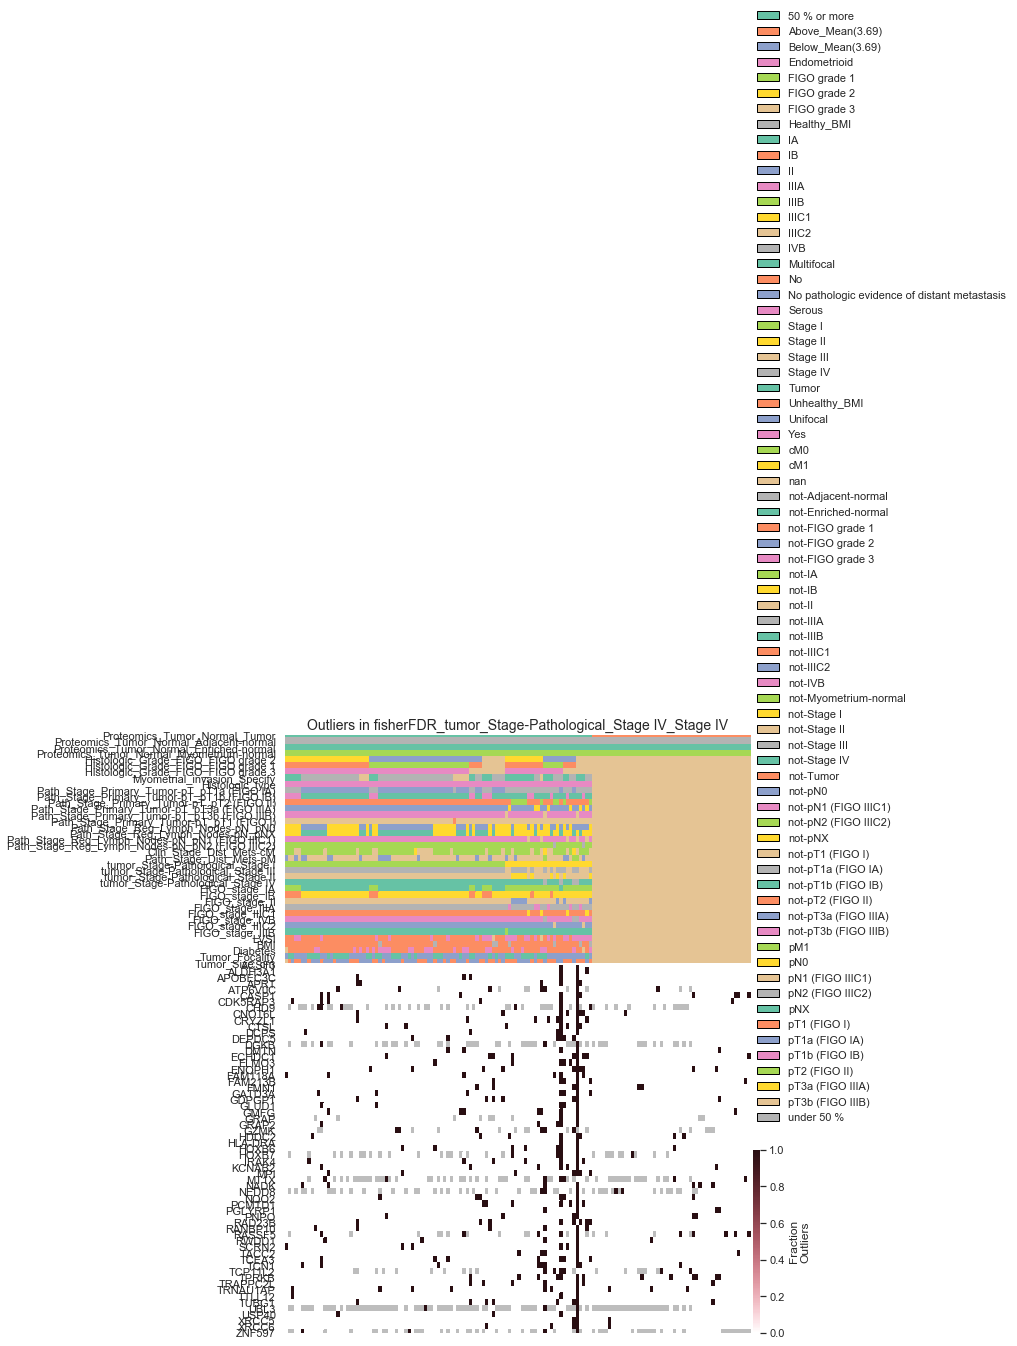

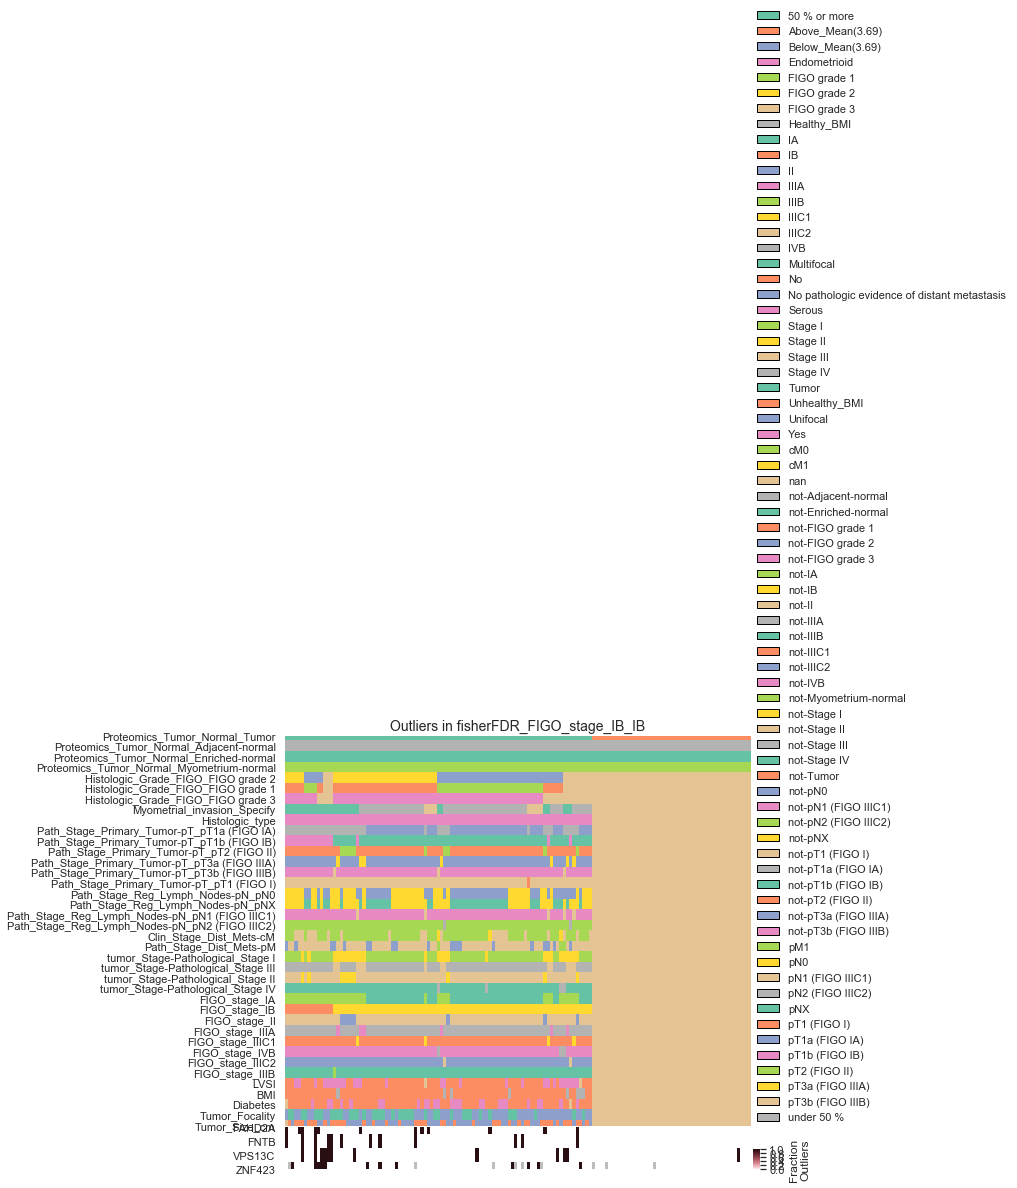

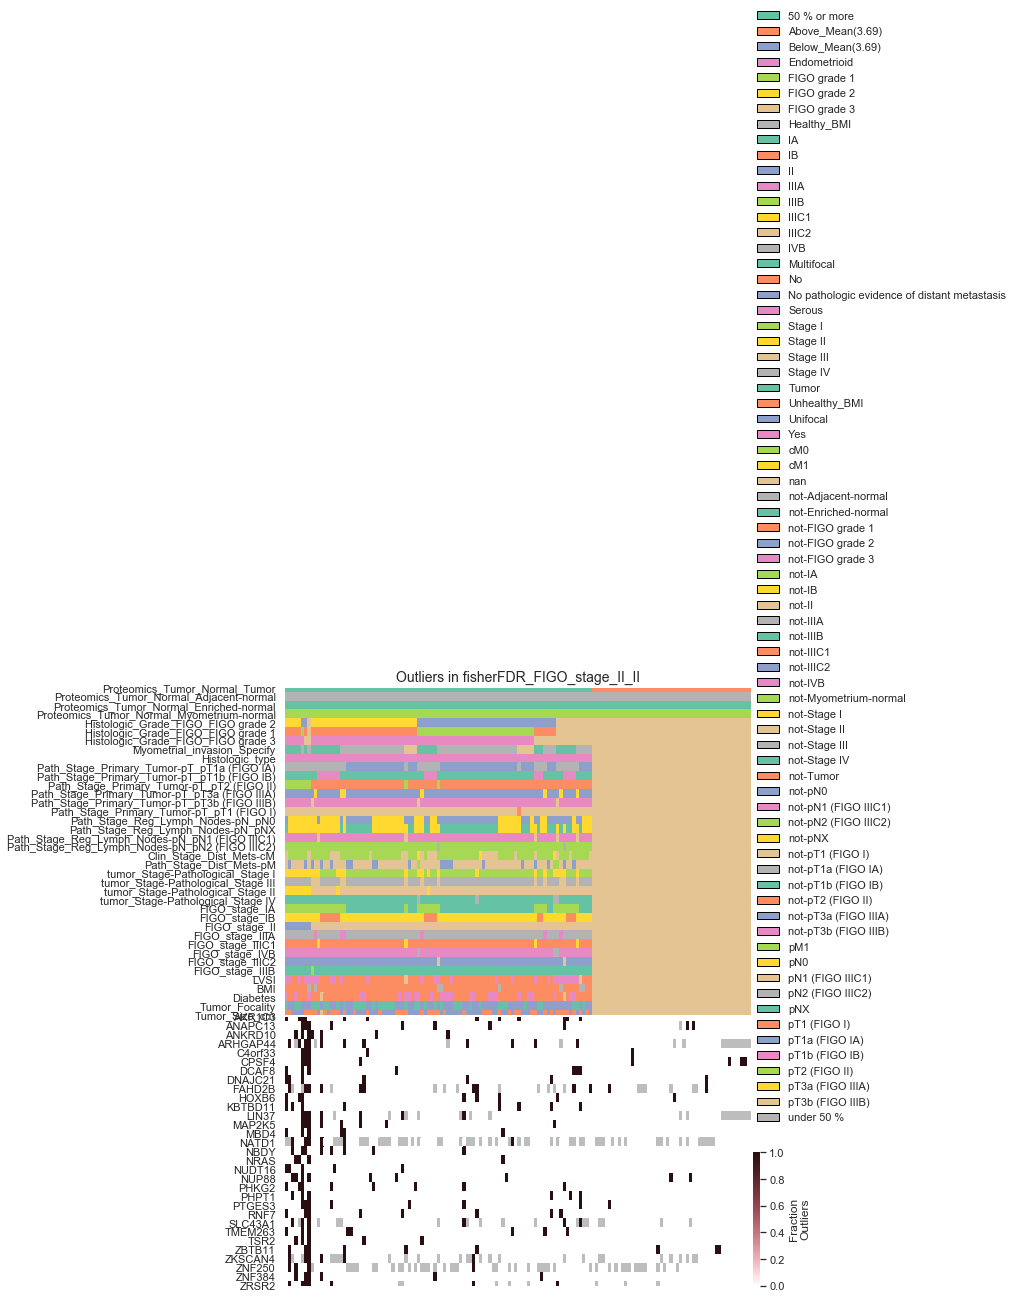

09/05/2019 14:09:59:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIA_IIIA


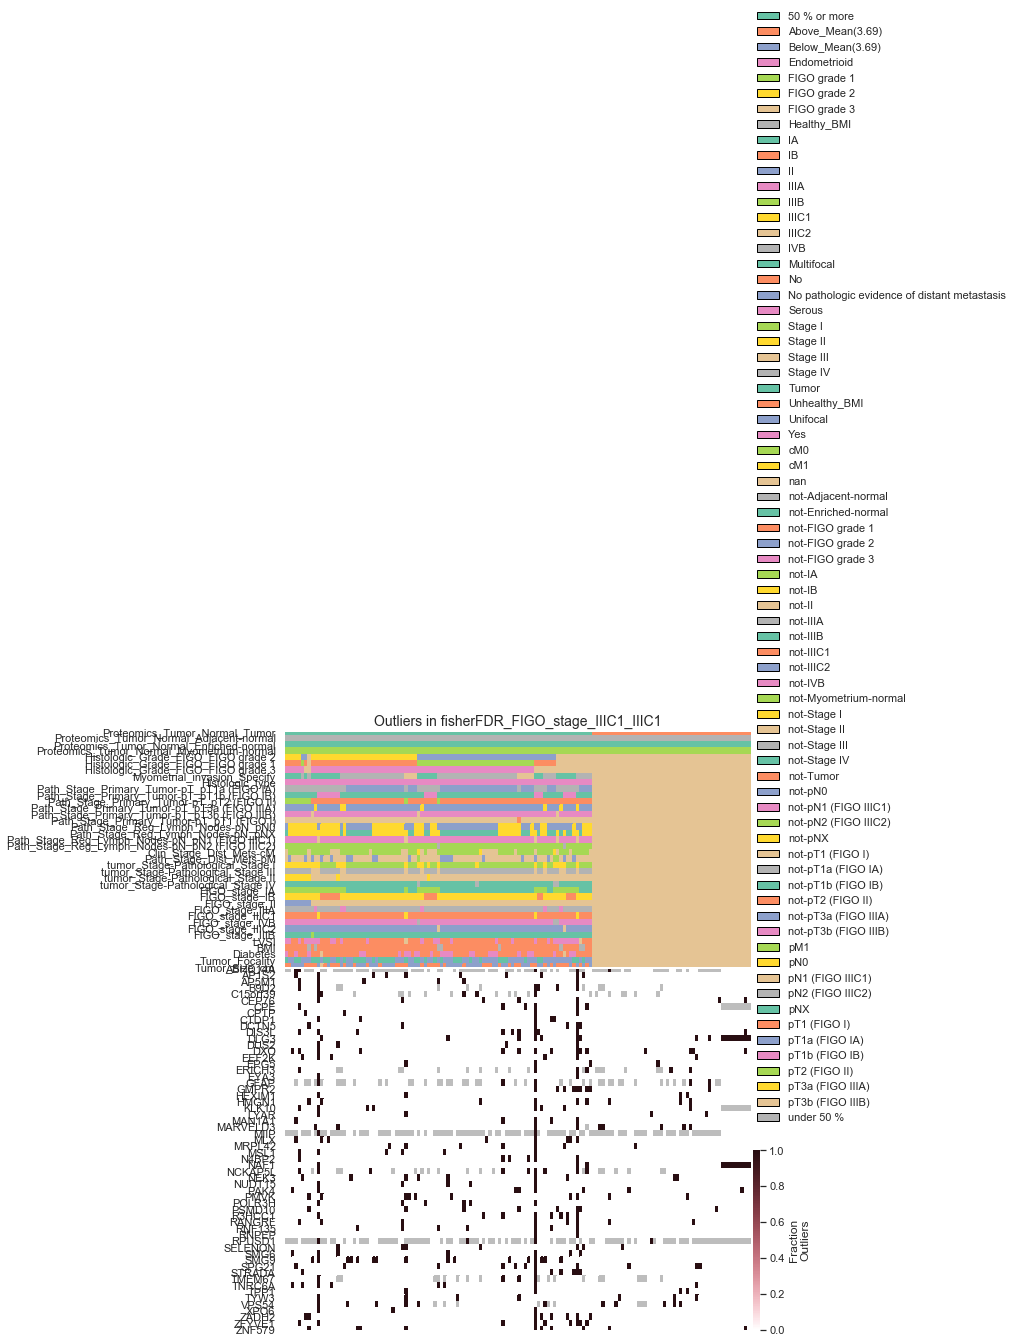

09/05/2019 14:10:10:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IVB_IVB
09/05/2019 14:10:10:WARNING:No significant genes at FDR 0.05 in fisherFDR_FIGO_stage_IIIC2_IIIC2


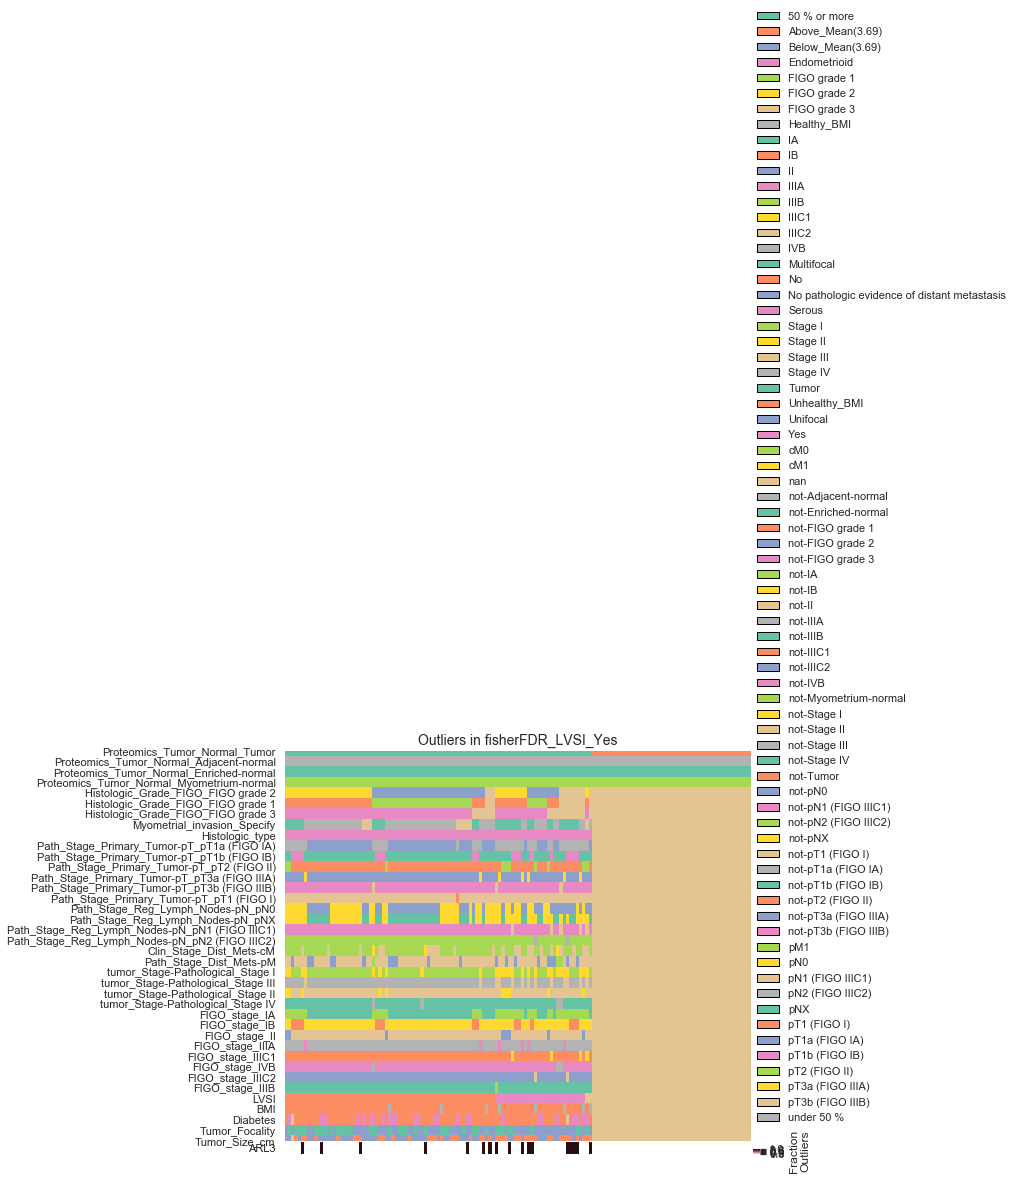

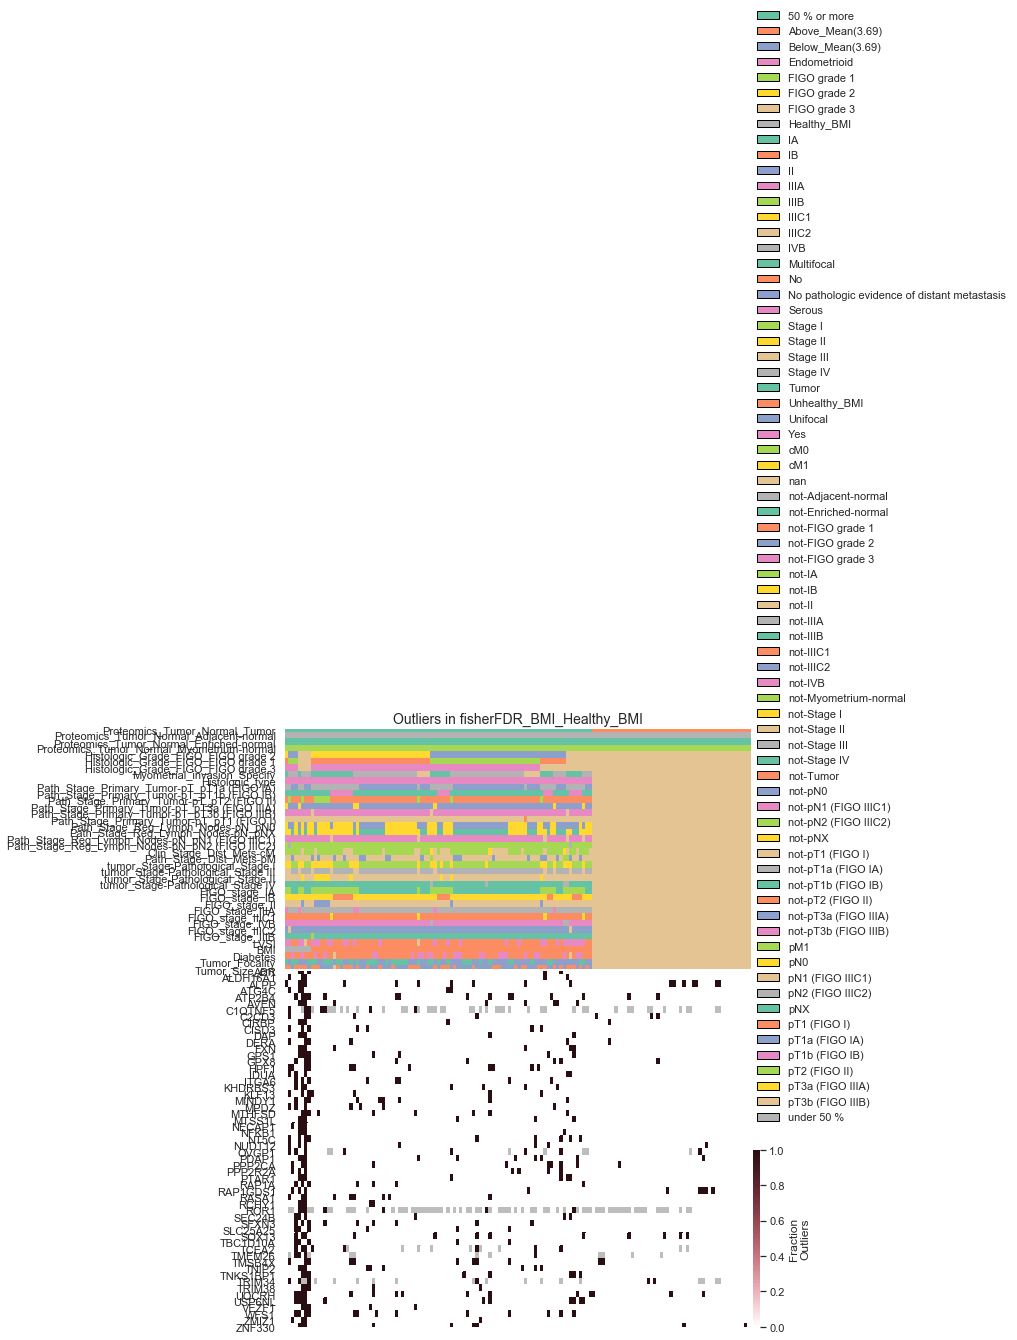

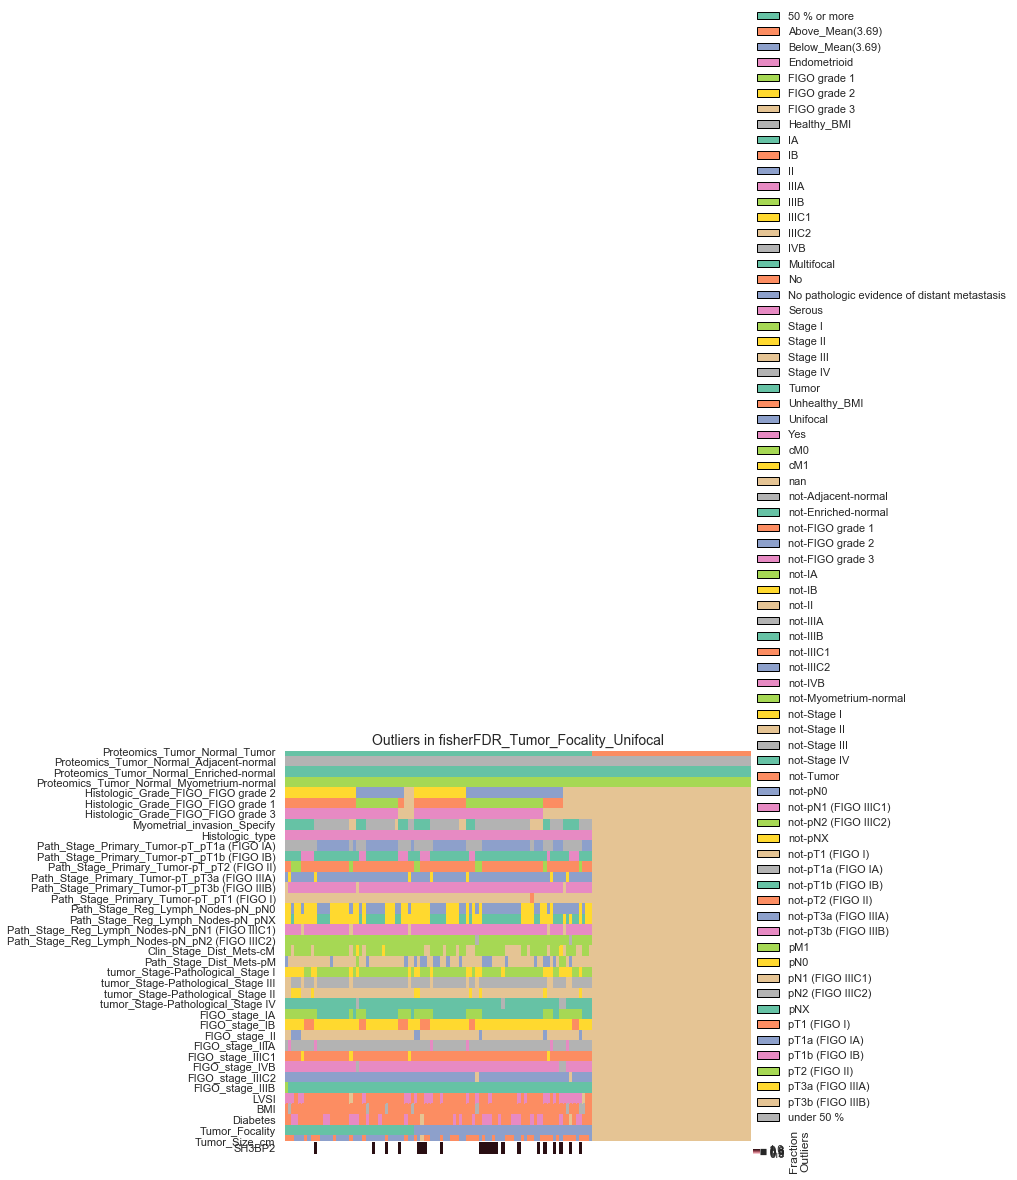

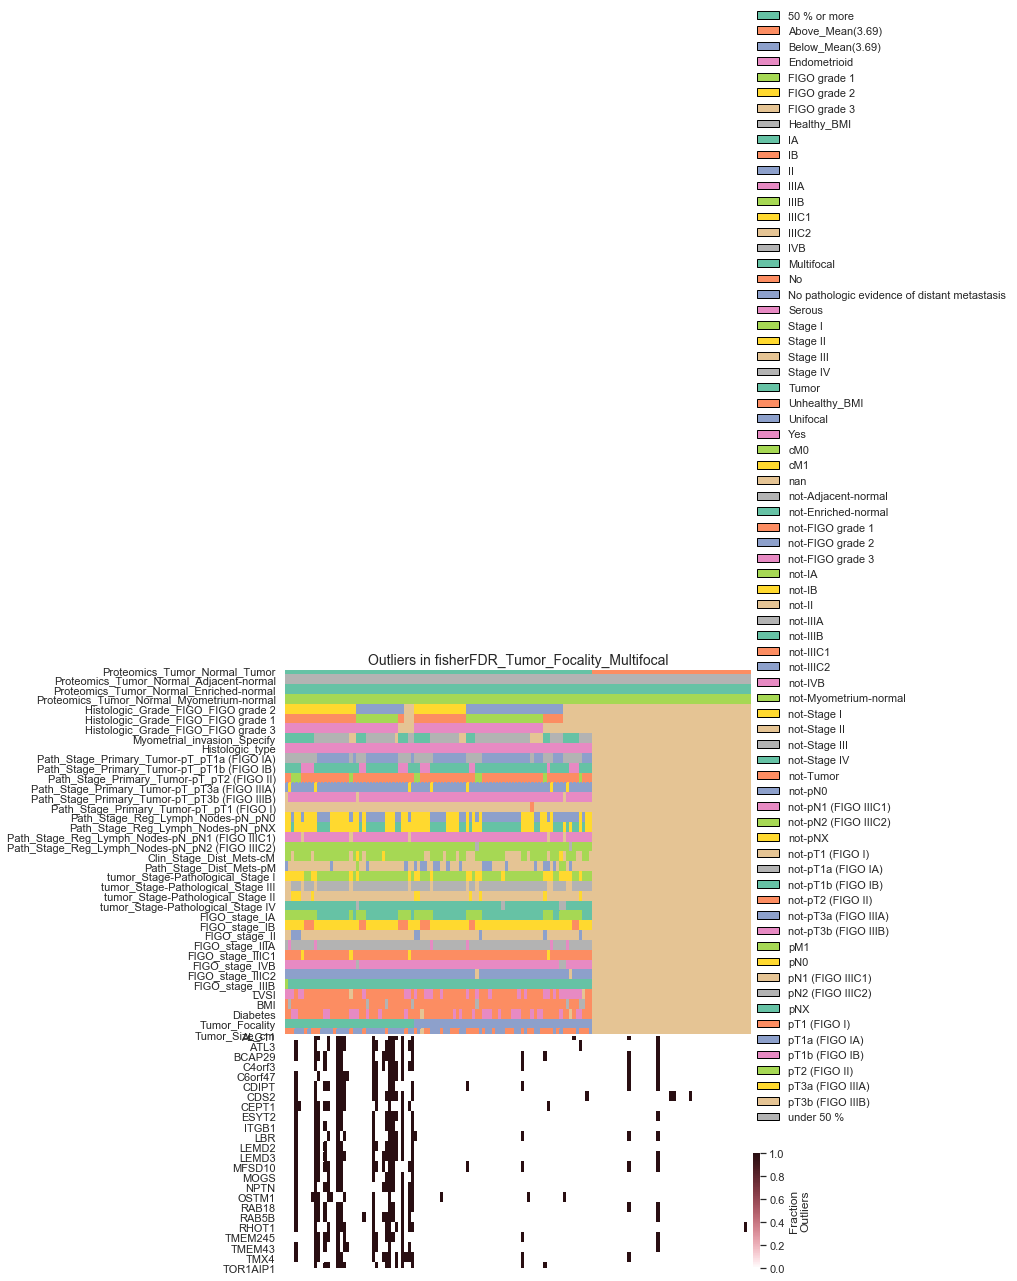

In [17]:
#Deva package visualization
for col in qvalues_down.df.columns:
    deva.plot_heatmap(
    annotations=annotations,
    qvals=qvalues_down.df,
    col_of_interest=col,
    vis_table=outliers_down.frac_table)
    
    plt.show()
    plt.close()

## Step 5: Perform Gene Set Enrichment Analysis

Part A: Up-regulated Genes

In [18]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(col.index)
    print('Gene List:', gene_name_list, '\n')
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/endo')
    gsea_up[col_name] = enrichment
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

fisherFDR_Proteomics_Tumor_Normal_Tumor_not-Tumor
Gene List: ['APCS', 'CEP250', 'EHD4', 'FTH1', 'FYCO1', 'GNLY', 'GUSB', 'MAP2K7', 'NDRG4', 'NPY', 'RBSN', 'RFTN1', 'WISP2', 'ZNF605'] 



2019-09-05 14:10:38,335 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:10:38:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3
Gene List: ['AARS', 'ACOT13', 'ACTR3', 'ADAR', 'AGA', 'ANKS1A', 'ARHGAP15', 'ARHGAP45', 'ARMC8', 'ATG4B', 'ATG5', 'ATP6V1C1', 'BCL7B', 'BIN2', 'BMF', 'BST2', 'C1orf52', 'CARS', 'CGAS', 'CNPY2', 'COTL1', 'COX20', 'CSNK2B', 'CYP2J2', 'DEF6', 'DHCR24', 'DHX30', 'DIS3', 'EIF2AK2', 'EIF3M', 'FARSB', 'FERMT3', 'FEZ2', 'FXR1', 'FYB1', 'GFM1', 'GLMP', 'GNS', 'GOPC', 'GP1BB', 'GRK2', 'HDLBP', 'HLA-C', 'HLA-DPB1', 'ID4', 'IDUA', 'IFI44', 'IFI44L', 'IL16', 'INPP5B', 'IRF4', 'KARS', 'KCNAB2', 'KIDINS220', 'KMT2C', 'LAGE3', 'LCP2', 'MANF', 'MAPK8IP3', 'MLX', 'MOV10', 'MT1F', 'MYO1B', 'MYO1G', 'NFATC2', 'NFU1', 'NME4', 'NOMO1', 'NVL', 'OASL', 'OLA1', 'OS9', 'OXSR1', 'PDK1', 'PDS5A', 'PHGDH', 'PLBD2', 'PLEKHF2', 'PPT1', 'PRDX1', 'PUS7L', 'PYGO2', 'RALYL', 'RIPK1', 'RNF115', 'RNF130', 'RPS6KB2', 'SAMHD1', 'SCGB1A1', 'SEC14L1', 'SEPT1', 'SLC11A2', 'SLC4A1AP', 'SLC7A2', 'SP100', 'SP110', 'SPAST', 'SPATA13', 'SPATS2L', 'SPRY1', 'STEAP3', 'STK10', 

2019-09-05 14:10:51,563 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:10:51:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_Path_Stage_Primary_Tumor-pT_pT2_(FIGO_II)_pT2_(FIGO_II)
Gene List: ['CYP4X1', 'HAUS2', 'MVD', 'TRMT2B', 'ZNF281'] 



2019-09-05 14:10:54,199 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:10:54:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)
Gene List: ['AKAP8', 'ARHGAP4', 'BABAM1', 'BPI', 'CARM1', 'CDA', 'CHIT1', 'CPVL', 'CTSS', 'CWF19L1', 'DDX56', 'DEFA3', 'DEFA4', 'ELANE', 'ENO1', 'FBXO2', 'GCA', 'GLRX3', 'GMFG', 'INTS8', 'ITGB6', 'KLC3', 'LAMA3', 'LAMB3', 'LAMC2', 'MET', 'MNDA', 'NCEH1', 'NIPBL', 'NSUN5', 'PARD6B', 'PIK3R2', 'POLD2', 'PRTN3', 'PSMB5', 'PUM3', 'RBM12', 'RBM33', 'SETD2', 'TACO1', 'TCERG1', 'TEX30', 'TNFSF10', 'VPS54', 'ZNF746'] 

fisherFDR_tumor_Stage-Pathological_Stage_IV_Stage_IV
Gene List: ['C5orf22', 'COL21A1', 'DCAF7', 'ENTPD5', 'FAAP100', 'FAM171A2', 'IGFBP2', 'LTBP3', 'MIS18BP1', 'SMAP1', 'SRPX2', 'TRIP12', 'TUT4'] 



2019-09-05 14:11:01,726 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:11:01:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_FIGO_stage_IB_IB
Gene List: ['AKR1C1', 'FAM98A', 'HAPLN1', 'IRF4', 'PITPNC1', 'PTGS1', 'SPRY1', 'SPRY4', 'STAT3', 'TFAP2A', 'WASF1'] 



2019-09-05 14:11:04,395 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:11:04:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_LVSI_Yes
Gene List: ['CWC22', 'ESF1', 'GLDC', 'HAPLN1', 'HAPLN3', 'IGF2BP3', 'KRI1', 'PA2G4', 'PAK1IP1', 'PRRC2A', 'XPO5'] 



2019-09-05 14:11:07,053 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:11:07:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


fisherFDR_BMI_Healthy_BMI
Gene List: ['ABHD14A-ACY1', 'ABT1', 'ACAD10', 'AKAP8L', 'ANKRD10', 'ARMC6', 'ASNA1', 'BAG6', 'BMP2K', 'BUB1', 'CCNK', 'CD47', 'CDK11B', 'CDK13', 'COLGALT1', 'CPS1', 'CUEDC2', 'DCAF13', 'DDX18', 'DDX52', 'DNTTIP2', 'DUSP11', 'DYNC1LI1', 'ERCC4', 'FAIM', 'FAM207A', 'FAM208A', 'FAM20A', 'FAM83D', 'GINS4', 'GLYCTK', 'GMPS', 'HELZ2', 'IGF2BP3', 'IMPDH2', 'IPO7', 'MDN1', 'MGRN1', 'MITD1', 'MTHFD1', 'NCAPD2', 'NCEH1', 'NDUFAF1', 'NOL10', 'NPM3', 'NR2C2AP', 'NSUN2', 'NUDT19', 'OSBPL11', 'OXSR1', 'PCNA', 'PDCD2L', 'PFDN6', 'POC1A', 'POLR1B', 'PSEN1', 'PTPN2', 'PUF60', 'PUS10', 'QRICH1', 'RANGAP1', 'RBBP6', 'RBM25', 'RCC1', 'RNMT', 'RPF1', 'RRP1', 'SCPEP1', 'SENP2', 'SEZ6L2', 'SLC25A19', 'SMG1', 'SON', 'SSB', 'TMEM205', 'TNFSF12-TNFSF13', 'TOMM6', 'TRIM26', 'TRMT5', 'TWISTNB', 'UBE2J2', 'UBR5', 'UROD', 'USP14', 'USP32', 'UTP3', 'UTP6', 'WDR75', 'XPNPEP3', 'XPO5', 'ZC3H14', 'ZNF330', 'ZNF552', 'ZNHIT6'] 



2019-09-05 14:11:09,829 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
09/05/2019 14:11:09:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, adn then for patients with invasive carcinoma.

In [42]:
gsea_sig_attributes = ['fisherFDR_Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3', 
                       'fisherFDR_Histologic_type_Serous', 
                       'fisherFDR_Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)']

gsea_sig_up_dict = {}

for attribute in gsea_sig_attributes:
    attribute += '_P_values'
    temp_df = gsea_up[attribute].res2d
    sig_filter = temp_df['Adjusted P-value'] < 0.05
    sig_terms = temp_df[sig_filter]
    gsea_sig_up_dict[attribute] = sig_terms
    print(attribute)
    print(gsea_sig_up_dict[attribute][['Term', 'Overlap', 'Adjusted P-value']])
    print('\n')

fisherFDR_Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3_P_values
                                       Term Overlap  Adjusted P-value
0                               Ferroptosis    4/40          0.024885
1  Human immunodeficiency virus 1 infection   7/212          0.034914


fisherFDR_Histologic_type_Serous_P_values
                                Term Overlap  Adjusted P-value
0  Ribosome biogenesis in eukaryotes  25/101      3.511333e-14
1                      RNA transport  26/165      3.813680e-10
2                        Spliceosome  23/134      7.691401e-10
3          mRNA surveillance pathway   15/91      4.555436e-06
4                     RNA polymerase    6/31      1.497268e-02
5           Hepatocellular carcinoma  14/168      2.268595e-02


fisherFDR_Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)_P_values
                             Term Overlap  Adjusted P-value
0                  Focal adhesion   6/199          0.001634
1        ECM-receptor interaction  

In [45]:
for k, v in gsea_sig_up_dict.items():
    print(k)
    print(v[['Term', 'Overlap', 'Adjusted P-value']])
    print('\n')

fisherFDR_Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3_P_values
                                       Term Overlap  Adjusted P-value
0                               Ferroptosis    4/40          0.024885
1  Human immunodeficiency virus 1 infection   7/212          0.034914


fisherFDR_Histologic_type_Serous_P_values
                                Term Overlap  Adjusted P-value
0  Ribosome biogenesis in eukaryotes  25/101      3.511333e-14
1                      RNA transport  26/165      3.813680e-10
2                        Spliceosome  23/134      7.691401e-10
3          mRNA surveillance pathway   15/91      4.555436e-06
4                     RNA polymerase    6/31      1.497268e-02
5           Hepatocellular carcinoma  14/168      2.268595e-02


fisherFDR_Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)_P_values
                             Term Overlap  Adjusted P-value
0                  Focal adhesion   6/199          0.001634
1        ECM-receptor interaction  

In [20]:
gsea_terms_and_genes = {}

for attribute, vals in gsea_sig_up_dict.items():
    genes = vals['Genes']
    terms = vals['Term']
    terms_and_genes = {}
    for i, gene in enumerate(genes):
        terms_and_genes[terms[i]] = gene.split(';')
    gsea_terms_and_genes[attribute] = terms_and_genes

In [21]:
figo3_dict = gsea_terms_and_genes['fisherFDR_Histologic_Grade_FIGO_FIGO_grade_3_FIGO_grade_3_P_values']
figo3_dict

{'Ferroptosis': ['STEAP3', 'SLC11A2', 'TP53', 'ATG5'],
 'Human immunodeficiency virus 1 infection': ['BST2',
  'RPS6KB2',
  'HLA-C',
  'NFATC2',
  'CGAS',
  'RIPK1',
  'SAMHD1']}

In [22]:
serous_dict = gsea_terms_and_genes['fisherFDR_Histologic_type_Serous_P_values']
serous_dict

{'Hepatocellular carcinoma': ['SMARCE1',
  'SMARCD1',
  'SMARCC1',
  'SMARCB1',
  'PHF10',
  'CDKN2A',
  'ACTL6A',
  'KEAP1',
  'WNT7A',
  'ARID1A',
  'SMARCA4',
  'BRD7',
  'TP53',
  'BCL2L1'],
 'RNA polymerase': ['POLR3A',
  'POLR3B',
  'POLR2B',
  'POLR3C',
  'POLR3E',
  'POLR3F'],
 'RNA transport': ['POP1',
  'GEMIN2',
  'EIF4A3',
  'NMD3',
  'CASC3',
  'FXR1',
  'PNN',
  'NXF1',
  'XPO1',
  'SUMO1',
  'SUMO3',
  'XPO5',
  'RAE1',
  'EIF4B',
  'UPF2',
  'UPF1',
  'ELAC2',
  'RPP40',
  'NUP153',
  'SENP2',
  'RANGAP1',
  'EIF5',
  'NUP50',
  'NXF2B',
  'TACC3',
  'GEMIN5'],
 'Ribosome biogenesis in eukaryotes': ['POP1',
  'WDR3',
  'HEATR1',
  'NAT10',
  'NMD3',
  'NOL6',
  'FBL',
  'NXF1',
  'XPO1',
  'RIOK1',
  'MDN1',
  'WDR36',
  'NOP58',
  'UTP6',
  'CSNK2A1',
  'UTP4',
  'RPP40',
  'WDR75',
  'IMP4',
  'UTP18',
  'TBL3',
  'LSG1',
  'CSNK2B',
  'NXF2B',
  'MPHOSPH10'],
 'Spliceosome': ['SF3B4',
  'TCERG1',
  'AQR',
  'RBM25',
  'SF3B2',
  'EIF4A3',
  'DDX23',
  'PRPF40A',
  'W

In [23]:
path_stage_pT3a = gsea_terms_and_genes['fisherFDR_Path_Stage_Primary_Tumor-pT_pT3a_(FIGO_IIIA)_pT3a_(FIGO_IIIA)_P_values']
path_stage_pT3a

{'Amoebiasis': ['LAMB3', 'LAMA3', 'LAMC2', 'PIK3R2'],
 'ECM-receptor interaction': ['LAMB3', 'LAMA3', 'LAMC2', 'ITGB6'],
 'Focal adhesion': ['LAMB3', 'LAMA3', 'LAMC2', 'PIK3R2', 'ITGB6', 'MET'],
 'Human papillomavirus infection': ['PARD6B',
  'LAMB3',
  'LAMA3',
  'LAMC2',
  'PIK3R2',
  'ITGB6'],
 'PI3K-Akt signaling pathway': ['LAMB3',
  'LAMA3',
  'LAMC2',
  'PIK3R2',
  'ITGB6',
  'MET'],
 'Small cell lung cancer': ['LAMB3', 'LAMA3', 'LAMC2', 'PIK3R2']}

## Step 6: Connect Findings with Druggable Genome Interactive Database (DGIdb)

In [24]:
figo3_requests = {}
figo3_requests_parsed = {}
for term, gene_list in figo3_dict.items():
    figo3_requests[term] = bf.dgidb_get_request(gene_list)
    figo3_requests_parsed[term] = bf.dgidb_json_parse(figo3_requests[term], genes=True)

print(json.dumps(figo3_requests_parsed, indent=4))

{
    "Ferroptosis": {
        "SLC11A2": {
            "CHEMBL259327": [
                "inhibitor"
            ]
        },
        "TP53": {
            "ASPIRIN": [
                "acetylation"
            ],
            "BORTEZOMIB": [
                "inhibitor"
            ],
            "HALOPERIDOL": [],
            "AMG-900": [],
            "EPIRUBICIN": [],
            "DABRAFENIB": [],
            "BEVACIZUMAB": [],
            "INK-128": [],
            "PROXYPHYLLINE": [],
            "DIETHYLSTILBESTROL": [],
            "AZD-6738": [],
            "STREPTONIGRIN": [],
            "Lesogaberan": [],
            "GEDATOLISIB": [],
            "URSODIOL": [],
            "DECITABINE": [],
            "PRAMLINTIDE": [],
            "IRINOTECAN": [],
            "TRAMETINIB": [],
            "DAUNORUBICIN": [],
            "ERLOTINIB": [],
            "SELICICLIB": [],
            "THIOTEPA": [],
            "CYCLOPHOSPHAMIDE": [],
            "GEMCITABINE": [],
         

In [25]:
serous_requests = {}
serous_requests_parsed = {}
for term, gene_list in serous_dict.items():
    serous_requests[term] = bf.dgidb_get_request(gene_list, anti_neoplastic=True)
    serous_requests_parsed[term] = bf.dgidb_json_parse(serous_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(serous_requests_parsed, indent=4))

Parsed Requests:

{
    "Ribosome biogenesis in eukaryotes": {
        "CSNK2A1": {
            "SILMITASERTIB": [
                "inhibitor"
            ],
            "RESVERATROL": []
        }
    },
    "RNA transport": null,
    "Spliceosome": null,
    "mRNA surveillance pathway": null,
    "RNA polymerase": null,
    "Hepatocellular carcinoma": {
        "SMARCB1": {
            "PALBOCICLIB": [],
            "PENTANAL": [],
            "PANOBINOSTAT": [],
            "ALVOCIDIB": [],
            "VORINOSTAT": [],
            "FENRETINIDE": []
        },
        "CDKN2A": {
            "GSK-461364": [],
            "CRIZOTINIB": [],
            "INK-128": [],
            "ALVOCIDIB": [],
            "PACLITAXEL": [],
            "ABEMACICLIB": [],
            "CHEMBL1231206": [],
            "GEMCITABINE": [],
            "TRAMETINIB": [],
            "PF-00477736": [],
            "LETROZOLE": [],
            "ILORASERTIB": [],
            "Ribociclib": [],
            "IMATI

In [26]:
pT3a_requests = {}
pT3a_requests_parsed = {}
for term, gene_list in path_stage_pT3a.items():
    pT3a_requests[term] = bf.dgidb_get_request(gene_list)
    pT3a_requests_parsed[term] = bf.dgidb_json_parse(pT3a_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(pT3a_requests_parsed, indent=4))

Parsed Requests:

{
    "Focal adhesion": {
        "LAMB3": {
            "OCRIPLASMIN": []
        },
        "LAMA3": {
            "OCRIPLASMIN": []
        },
        "LAMC2": {
            "OCRIPLASMIN": []
        },
        "PIK3R2": {
            "RG-7666": [
                "inhibitor"
            ],
            "WX-037": [
                "inhibitor"
            ],
            "PF-04691502": [
                "inhibitor"
            ],
            "Puquitinib": [
                "inhibitor"
            ],
            "PA-799": [
                "inhibitor"
            ],
            "ISOPRENALINE": [
                "agonist"
            ],
            "COPANLISIB": [
                "inhibitor"
            ],
            "DS-7423": [
                "inhibitor"
            ],
            "GSK-1059615": [
                "inhibitor"
            ],
            "OMIPALISIB": [
                "inhibitor"
            ],
            "RECILISIB": [
                "inhibitor"
   

}


## Step 7: Personalized Medicine

In [27]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [28]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "fisherFDR_Proteomics_Tumor_Normal_Tumor_not-Tumor": {
        "MAP2K7": {
            "AZD-8330": [
                "inhibitor"
            ],
            "BINIMETINIB": [
                "inhibitor"
            ],
            "DABRAFENIB MESYLATE": [
                "inhibitor"
            ],
            "COBIMETINIB": [
                "allosteric modulator",
                "inhibitor"
            ],
            "PD-0325901": [
                "inhibitor"
            ],
            "TRAMETINIB": [
                "inhibitor"
            ],
            "Refametinib": [
                "inhibitor"
            ],
            "IODOACETAMIDE": [
                "inhibitor"
            ],
            "SELUMETINIB": [
                "inhibitor"
            ]
        }
    },
    "fisherFDR_Histologic_Grade_FIGO_FIGO grade 3_FIGO grade 3": {
        "CYP2J2": {
            "TERFENADINE": [
                "inhibitor"
            ]
        },
        

}


In [29]:
random.seed(8)
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    while clinical.index[index] not in outliers_up_dict.keys() and index < len(outliers_up_dict.keys()):
        index += 1
    patients_to_check_up.append(clinical.index[index])

In [30]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

{
    "S066": {
        "ADA": {
            "CLADRIBINE": [
                "inhibitor"
            ],
            "DIPYRIDAMOLE": [
                "inhibitor"
            ],
            "EHNA": [
                "inhibitor"
            ],
            "PENTOSTATIN": [
                "inhibitor"
            ],
            "FLUDARABINE": [
                "inhibitor"
            ]
        },
        "AKR1A1": {
            "FOMEPIZOLE": [
                "inhibitor"
            ]
        },
        "AKR1C1": {
            "SALICYLIC ACID": [
                "inhibitor"
            ],
            "ASPIRIN": [
                "inhibitor"
            ]
        },
        "ATP6V1A": {
            "TILUDRONIC ACID": [
                "inhibitor"
            ],
            "BAFILOMYCIN A1": [
                "inhibitor"
            ],
            "BAFILOMYCIN B1": [
                "inhibitor"
            ]
        },
        "ATP6V1B2": {
            "GALLIUM NITRATE": [
                "i

}
